# Load libraries

Важно: Не успях директно да копирам kaggle.json файла и затова първо се свързвам към Google Drive. Ще трябва да промените работната си директория по-долу, ако ще ползвате този код.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
# mainDirectory = "/content/drive" + "/MyDrive/Colab Notebooks/BirdCLEF" # Трябва да се смени това, ако подкарвате тетрадката във вашия драйв
# mainDirectory = "/content/drive" + "/MyDrive/TF_Project/Aleksis" # Трябва да се смени това, ако подкарвате тетрадката във вашия драйв
mainDirectory = "/content/drive/MyDrive/Colab Notebooks/TF_Project/Boyko"
fileName = mainDirectory + "/kaggle.json"

In [ ]:
! mkdir ~/.kaggle
! cp "{fileName}" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir ./cache

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/TF_Project/Boyko/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Tensorflow utilities
!pip install -q tensorflow-addons
!pip install -q tensorflow-probability
!pip install -q tensorflow-io
!pip install -q tensorflow_extra

# Other utilies
!pip install -q opencv-python-headless
!pip install -q librosa
!pip install -q scikit-learn

# Kaggle
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 49.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import zipfile
import csv
import pandas as pd
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc
import datetime
import json

import librosa
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Import for visualization
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd
import cv2

# Import tensorflow
import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)

from tensorflow.keras.models import Model

from tensorflow.keras.layers import (
    Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
    MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,
    Bidirectional, Normalization, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, MaxPool2D, Activation, Flatten, Normalization)
from tensorflow.keras.optimizers import Adam

# Import required tensorflow modules
import tensorflow_io as tfio
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import tensorflow_extra as tfe

# Download and extract data

In [ ]:
! kaggle competitions download birdclef-2023

100% 4.90G/4.91G [00:52<00:00, 202MB/s]
100% 4.91G/4.91G [00:52<00:00, 101MB/s]


In [ ]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/TF_Project/birdclef-2023.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
!rm birdclef-2023.zip

In [ ]:
!ls train_audio

abethr1  blaplo1  carcha1  fatrav1  hartur1  mouwag1  rehblu1  spmthr1	wheslf1
abhori1  blbpuf2  carwoo1  fatwid1  helgui   ndcsun2  rehwea1  spwlap1	whhsaw1
abythr1  blcapa2  categr   fislov1  hipbab1  nobfly1  reisee2  squher1	whihel1
afbfly1  blfbus1  ccbeat1  fotdro5  hoopoe   norbro1  rerswa1  strher	whrshr1
afdfly1  blhgon1  chespa1  gabgos2  huncis1  norcro1  rewsta1  strsee1	witswa1
afecuc1  blhher1  chewea1  gargan   hunsun2  norfis1  rindov   stusta1	wlwwar
affeag1  blksaw1  chibat1  gbesta1  joygre1  norpuf1  rocmar2  subbus1	wookin1
afgfly1  blnmou1  chtapa3  gnbcam2  kerspa2  nubwoo1  rostur1  supsta1	woosan
afghor1  blnwea1  chucis1  gnhsun1  klacuc1  pabspa1  ruegls1  tacsun1	wtbeat1
afmdov1  bltapa1  cibwar1  gobbun1  kvbsun1  palfly2  rufcha2  tafpri1	yebapa1
afpfly1  bltbar1  cohmar1  gobsta5  laudov1  palpri1  sacibi2  tamdov1	yebbar1
afpkin1  bltori1  colsun2  gobwea1  lawgol   piecro1  sccsun2  thrnig1	yebduc1
afpwag1  blwlap1  combul2  golher1  lesmaw1  piekin1  s

# Configuration

In [ ]:
class CFG:
    # Random seed
    seed = 42

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    participate_thr = 30 # min number of samples in order to participate in the sets
    upsample_thr = 50 # min sample of each class in training set (upsample)

    # Audio duration, sample rate, and length
    duration = 10 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    preferred_chunks = 3

    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True

    # Training and validation size
    train_proportion = 0.7
    test_validation_split_proportion = 0.7

    # Spectrogram output channels
    out_channels = 3

    # Number of epochs
    epochs = 30

    # Learning rate
    lr = 1e-3

    # Label smoothing
    label_smoothing = 0.05

    # Time Freq masking
    freq_mask_prob=0.50
    num_freq_masks=1
    freq_mask_param=10
    time_mask_prob=0.50
    num_time_masks=2
    time_mask_param=25

    # Audio Augmentation Settings
    noise_prob = 0.5
    min_std = 0.0025
    max_std = 0.025

    mixup_prob = 0.65
    mixup_alpha = 0.3

    cutmix_prob = 0.65
    cutmix_alpha = 1.5

In [ ]:
tf.keras.utils.set_random_seed(CFG.seed)

# Explore the data

In [ ]:
dirpaths = []

In [ ]:
for dirpath, dirnames, filenames in os.walk("train_audio"):
    c = dirpath.split('/')
    if len(c) > 1:
        c = c[1]
    dirpaths.append((dirpath, len(filenames), c))
    print(f"There are {len(dirnames)} directories and {len(filenames)} audio files in '{dirpath}'.")

There are 264 directories and 0 audio files in 'train_audio'.
There are 0 directories and 108 audio files in 'train_audio/yewgre1'.
There are 0 directories and 1 audio files in 'train_audio/whctur2'.
There are 0 directories and 67 audio files in 'train_audio/wookin1'.
There are 0 directories and 9 audio files in 'train_audio/bubwar2'.
There are 0 directories and 425 audio files in 'train_audio/cohmar1'.
There are 0 directories and 500 audio files in 'train_audio/thrnig1'.
There are 0 directories and 79 audio files in 'train_audio/chibat1'.
There are 0 directories and 38 audio files in 'train_audio/blfbus1'.
There are 0 directories and 15 audio files in 'train_audio/loceag1'.
There are 0 directories and 2 audio files in 'train_audio/rehblu1'.
There are 0 directories and 104 audio files in 'train_audio/afpfly1'.
There are 0 directories and 18 audio files in 'train_audio/afbfly1'.
There are 0 directories and 3 audio files in 'train_audio/brcsta1'.
There are 0 directories and 41 audio file

In [ ]:
'train_audio/quailf1'.split('/')

['train_audio', 'quailf1']

In [ ]:
dirpaths.sort(key=lambda x: x[1], reverse = True)


In [ ]:
dirpaths[:10]

[('train_audio/thrnig1', 500, 'thrnig1'),
 ('train_audio/comsan', 500, 'comsan'),
 ('train_audio/eaywag1', 500, 'eaywag1'),
 ('train_audio/barswa', 500, 'barswa'),
 ('train_audio/wlwwar', 500, 'wlwwar'),
 ('train_audio/woosan', 486, 'woosan'),
 ('train_audio/combuz1', 477, 'combuz1'),
 ('train_audio/eubeat1', 437, 'eubeat1'),
 ('train_audio/hoopoe', 436, 'hoopoe'),
 ('train_audio/cohmar1', 425, 'cohmar1')]

In [ ]:
sum(map(lambda x: x[1], dirpaths))

16941

In [ ]:
metadata = pd.read_csv("train_metadata.csv")
metadata

primary_label secondary_labels              type  latitude  longitude  \
0           abethr1               []          ['song']    4.3906    38.2788   
1           abethr1               []          ['call']   -2.9524    38.2921   
2           abethr1               []          ['song']   -2.9524    38.2921   
3           abethr1               []          ['song']   -2.9524    38.2921   
4           abethr1               []  ['call', 'song']   -2.9524    38.2921   
...             ...              ...               ...       ...        ...   
16936       yewgre1               []              ['']   -1.2502    29.7971   
16937       yewgre1               []              ['']   -1.2489    29.7923   
16938       yewgre1               []              ['']   -1.2433    29.7844   
16939       yewgre1               []              ['']    0.0452    36.3699   
16940       yewgre1               []              ['']   -0.3986    37.3087   

            scientific_name                common_name          author  \
0        Turdus tephronotus   African Bare-eyed Thrush   Rolf A. de By   
1        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
2        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
3        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
4        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
...                     ...                        ...             ...   
16936  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16937  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16938  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16939  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   
16940  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   

                                                 license  rating  \
0      Creative Commons Attribution-NonCommercial-Sha...     4.0   
1      Creative Commons Attribution-NonCommercial-Sha...     3.5   
2      Creative Commons Attribution-NonCommercial-Sha...     3.5   
3      Creative Commons Attribution-NonCommercial-Sha...     5.0   
4      Creative Commons Attribution-NonCommercial-Sha...     4.5   
...                                                  ...     ...   
16936  Creative Commons Attribution-NonCommercial-Sha...     3.0   
16937  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16938  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16939  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16940  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                                     url              filename  
0      https://www.xeno-canto.org/128013  abethr1/XC128013.ogg  
1      https://www.xeno-canto.org/363501  abethr1/XC363501.ogg  
2      https://www.xeno-canto.org/363502  abethr1/XC363502.ogg  
3      https://www.xeno-canto.org/363503  abethr1/XC363503.ogg  
4      https://www.xeno-canto.org/363504  abethr1/XC363504.ogg  
...                                  ...                   ...  
16936      https://xeno-canto.org/703472  yewgre1/XC703472.ogg  
16937      https://xeno-canto.org/703485  yewgre1/XC703485.ogg  
16938      https://xeno-canto.org/704433  yewgre1/XC704433.ogg  
16939      https://xeno-canto.org/752974  yewgre1/XC752974.ogg  
16940      https://xeno-canto.org/753190  yewgre1/XC753190.ogg  

[16941 rows x 12 columns]

In [ ]:
assert len(metadata[metadata['primary_label'].isna()] ) + len(metadata[metadata['common_name'].isna()]) == 0

In [ ]:
num_labels = len(metadata[['primary_label', 'common_name']].drop_duplicates())
num_labels

264

In [ ]:
class2bird = metadata[['primary_label', 'common_name']].drop_duplicates().set_index('primary_label').to_dict()['common_name']

In [ ]:
taxonomy = pd.read_csv("eBird_Taxonomy_v2021.csv")
taxonomy

TAXON_ORDER CATEGORY SPECIES_CODE         PRIMARY_COM_NAME  \
0                1  species      ostric2           Common Ostrich   
1                6  species      ostric3           Somali Ostrich   
2                7    slash       y00934    Common/Somali Ostrich   
3                8  species      grerhe1             Greater Rhea   
4               14  species      lesrhe2              Lesser Rhea   
...            ...      ...          ...                      ...   
16748        34694  species      slcgro1   Slate-colored Grosbeak   
16749        34697  species      bltgro2  Black-throated Grosbeak   
16750        34698     spuh      saltat1             saltator sp.   
16751        34699     spuh      passer1            passerine sp.   
16752        35000     spuh        bird1                 bird sp.   

                             SCI_NAME            ORDER1  \
0                    Struthio camelus  Struthioniformes   
1              Struthio molybdophanes  Struthioniformes   
2      Struthio camelus/molybdophanes  Struthioniformes   
3                      Rhea americana        Rheiformes   
4                        Rhea pennata        Rheiformes   
...                               ...               ...   
16748                Saltator grossus     Passeriformes   
16749            Saltator fuliginosus     Passeriformes   
16750                    Saltator sp.     Passeriformes   
16751               Passeriformes sp.     Passeriformes   
16752                        Aves sp.               NaN   

                                 FAMILY SPECIES_GROUP REPORT_AS  
0             Struthionidae (Ostriches)     Ostriches       NaN  
1             Struthionidae (Ostriches)           NaN       NaN  
2             Struthionidae (Ostriches)           NaN       NaN  
3                       Rheidae (Rheas)         Rheas       NaN  
4                       Rheidae (Rheas)           NaN       NaN  
...                                 ...           ...       ...  
16748  Thraupidae (Tanagers and Allies)           NaN       NaN  
16749  Thraupidae (Tanagers and Allies)           NaN       NaN  
16750  Thraupidae (Tanagers and Allies)           NaN       NaN  
16751                               NaN        Others       NaN  
16752                               NaN           NaN       NaN  

[16753 rows x 9 columns]

In [ ]:
train_dirs = list(map(lambda x: x[0], dirpaths[:-1]))
train_dirs[:10]

['train_audio/thrnig1',
 'train_audio/comsan',
 'train_audio/eaywag1',
 'train_audio/barswa',
 'train_audio/wlwwar',
 'train_audio/woosan',
 'train_audio/combuz1',
 'train_audio/eubeat1',
 'train_audio/hoopoe',
 'train_audio/cohmar1']

In [ ]:
assert len(class2bird) == num_labels

In [ ]:
dir_labels = list(map(lambda x: x[2], dirpaths[:-1]))
dir_labels = list(map(lambda x: class2bird[x], dir_labels))
dir_labels[:10]

['Thrush Nightingale',
 'Common Sandpiper',
 'Western Yellow Wagtail',
 'Barn Swallow',
 'Willow Warbler',
 'Wood Sandpiper',
 'Common Buzzard',
 'European Bee-eater',
 'Eurasian Hoopoe',
 'Common House-Martin']

In [ ]:
train_files = []
train_labels = []
for i in range(len(dir_labels)):
    for dirpath, dirnames, filenames in os.walk(train_dirs[i]):
        train_files = train_files + list(map(lambda x: train_dirs[i] + '/' + x , filenames))
        train_labels = train_labels + len(filenames) * [dir_labels[i]]

In [ ]:
train_files[:10], train_labels[:10]

(['train_audio/thrnig1/XC247266.ogg',
  'train_audio/thrnig1/XC563330.ogg',
  'train_audio/thrnig1/XC244682.ogg',
  'train_audio/thrnig1/XC575231.ogg',
  'train_audio/thrnig1/XC569436.ogg',
  'train_audio/thrnig1/XC492465.ogg',
  'train_audio/thrnig1/XC208269.ogg',
  'train_audio/thrnig1/XC298473.ogg',
  'train_audio/thrnig1/XC559755.ogg',
  'train_audio/thrnig1/XC243986.ogg'],
 ['Thrush Nightingale',
  'Thrush Nightingale',
  'Thrush Nightingale',
  'Thrush Nightingale',
  'Thrush Nightingale',
  'Thrush Nightingale',
  'Thrush Nightingale',
  'Thrush Nightingale',
  'Thrush Nightingale',
  'Thrush Nightingale'])

## Creating label encoder for the bird labels

This is a necessary first step in order to create One-Hot Encoding Later. The inverse transform will be used to get the Label name from the corresponding number.

In [ ]:
birds_label_encoder = LabelEncoder()

birds_label_encoder.fit(dir_labels)
birds_label_encoder.transform(dir_labels)

array([221,  74, 228,  21, 245, 247,  72,  89,  88,  73, 133,  71, 171,
        25, 111, 103, 183, 201,  70, 169,  29,  62, 220,  60,  85, 110,
        93,  95, 259, 235, 117,   2, 175, 164, 214, 186,  68,  31, 128,
       263, 255, 223,  13, 113, 222, 219, 210, 114, 163,   6, 216, 224,
        14,  42,  56,  97,  66,  79, 192, 236,  24, 257, 233,  10, 106,
       134, 176, 129, 195, 248,  55,  86,  53,  23, 120, 180, 211,   8,
       127, 174, 107, 165, 105, 196,  41,  77, 212, 240,   7, 172,  28,
       155, 112,  17, 194, 168,  18,  61, 177, 204, 206, 144, 131,  50,
        33,  47, 217, 148, 207, 146,  76, 250,  59, 161, 227,  22,  94,
       125, 252, 190, 198, 213, 145,  78, 208,   5, 199, 118,  12,  58,
        48, 147,  45, 260,  67, 132, 100, 244, 157,   0, 184,  32, 262,
        44,  65, 231,  43, 116,  90,  11, 185, 191,  20, 153, 108, 232,
        34, 197, 158,  30,  49, 200, 187, 251, 203, 152, 173, 202,  82,
       102,  37, 151, 156, 154, 241, 139, 249, 115, 225,   3, 11

## Display audio and spectrogram

In [ ]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

In [ ]:
def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio,
                                   sr=CFG.sample_rate,
                                   n_mels=CFG.img_size[0],
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    return spec

In [ ]:
def display_audio(filepath, label):
    # Caption
    caption = f'File: {filepath} | Bird label: {label}'
    # Read audio file
    audio, sr = load_audio(filepath)
    # Keep fixed length audio
    ### audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    # Display spectrogram
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                color= cmap(0.1))
    # Specplot
    lid.specshow(spec,
                 sr = CFG.sample_rate,
                 hop_length = CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time',
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

# Audio:


# Visualization:


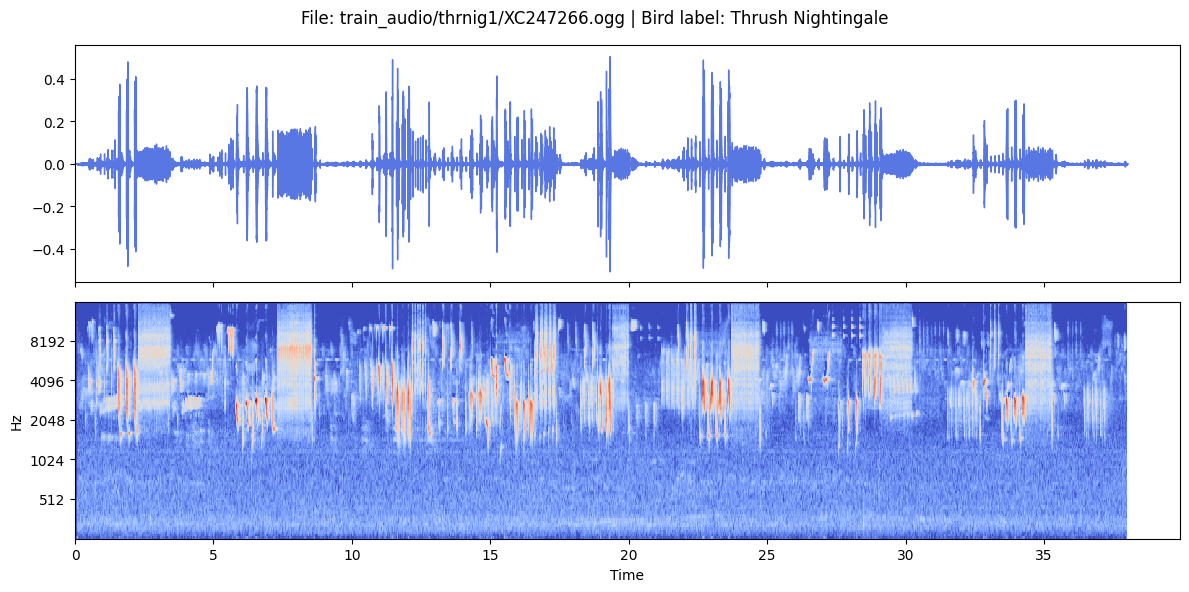

In [ ]:
display_audio(train_files[0], train_labels[0])

# Create train and validation datasets

In [ ]:
all_data = {"File": train_files,
            "Label": train_labels}
all_data = pd.DataFrame(all_data)

In [ ]:
all_data = all_data.sort_values(by='File')
all_data = all_data.reset_index(drop=True)

In [ ]:
all_data

File                      Label
0      train_audio/abethr1/XC128013.ogg   African Bare-eyed Thrush
1      train_audio/abethr1/XC363501.ogg   African Bare-eyed Thrush
2      train_audio/abethr1/XC363502.ogg   African Bare-eyed Thrush
3      train_audio/abethr1/XC363503.ogg   African Bare-eyed Thrush
4      train_audio/abethr1/XC363504.ogg   African Bare-eyed Thrush
...                                 ...                        ...
16936  train_audio/yewgre1/XC703472.ogg  Yellow-whiskered Greenbul
16937  train_audio/yewgre1/XC703485.ogg  Yellow-whiskered Greenbul
16938  train_audio/yewgre1/XC704433.ogg  Yellow-whiskered Greenbul
16939  train_audio/yewgre1/XC752974.ogg  Yellow-whiskered Greenbul
16940  train_audio/yewgre1/XC753190.ogg  Yellow-whiskered Greenbul

[16941 rows x 2 columns]

## Encoding the Label

In [ ]:
all_data.Label = birds_label_encoder.transform(all_data.Label)

In [ ]:
all_data

File  Label
0      train_audio/abethr1/XC128013.ogg      1
1      train_audio/abethr1/XC363501.ogg      1
2      train_audio/abethr1/XC363502.ogg      1
3      train_audio/abethr1/XC363503.ogg      1
4      train_audio/abethr1/XC363504.ogg      1
...                                 ...    ...
16936  train_audio/yewgre1/XC703472.ogg    263
16937  train_audio/yewgre1/XC703485.ogg    263
16938  train_audio/yewgre1/XC704433.ogg    263
16939  train_audio/yewgre1/XC752974.ogg    263
16940  train_audio/yewgre1/XC753190.ogg    263

[16941 rows x 2 columns]

## Filtering labels with too few examples

There are some labels with too few examples. We will exclude them.

In [ ]:
def filter_data(df, thr=CFG.participate_thr):
    # Count the number of samples for each class
    counts = df.Label.value_counts()

    # Condition that selects classes with less than `thr` samples
    cond = df.Label.isin(counts[counts<thr].index.tolist())

    # Add a new column to select the samples that will be included
    df['Include'] = True

    # Set False for those class where there is samples less than thr
    df.loc[cond, 'Include'] = False

    # Return the filtered dataframe
    return df

The rows with `Validation=False` will participate only in the training data.

In [ ]:
all_data = filter_data(all_data, thr=CFG.participate_thr)
all_data

File  Label  Include
0      train_audio/abethr1/XC128013.ogg      1    False
1      train_audio/abethr1/XC363501.ogg      1    False
2      train_audio/abethr1/XC363502.ogg      1    False
3      train_audio/abethr1/XC363503.ogg      1    False
4      train_audio/abethr1/XC363504.ogg      1    False
...                                 ...    ...      ...
16936  train_audio/yewgre1/XC703472.ogg    263     True
16937  train_audio/yewgre1/XC703485.ogg    263     True
16938  train_audio/yewgre1/XC704433.ogg    263     True
16939  train_audio/yewgre1/XC752974.ogg    263     True
16940  train_audio/yewgre1/XC753190.ogg    263     True

[16941 rows x 3 columns]

In [ ]:
len(all_data[all_data.Include == False])

1902

## Splitting train and validation sets

In [ ]:
exclude_data = all_data[all_data.Include == False].drop(columns=["Include"])

In [ ]:
to_split_data = all_data[all_data.Include == True].drop(columns=["Include"])

In [ ]:
train_data, test_validation_data = train_test_split(to_split_data, train_size = CFG.train_proportion, random_state = CFG.seed, stratify = to_split_data.Label)
test_data, validation_data = train_test_split(test_validation_data, train_size = CFG.test_validation_split_proportion, random_state = CFG.seed, stratify = test_validation_data.Label)

In [ ]:
# train_data = pd.concat([train_data, exclude_data])
train_data = train_data.reset_index(drop=True)

validation_data = validation_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [ ]:
train_data

File  Label
0      train_audio/cohmar1/XC713342.ogg     73
1      train_audio/thrnig1/XC740276.ogg    221
2      train_audio/yertin1/XC633675.ogg    259
3      train_audio/cibwar1/XC690370.ogg     68
4      train_audio/tafpri1/XC452376.ogg    220
...                                 ...    ...
10522   train_audio/wlwwar/XC181236.ogg    245
10523  train_audio/combul2/XC440111.ogg     71
10524  train_audio/eaywag1/XC543956.ogg    228
10525  train_audio/cohmar1/XC656615.ogg     73
10526  train_audio/colsun2/XC174854.ogg     70

[10527 rows x 2 columns]

In [ ]:
validation_data

File  Label
0     train_audio/afrthr1/XC253101.ogg     17
1     train_audio/chibat1/XC492740.ogg     66
2     train_audio/reccuc1/XC497376.ogg    175
3     train_audio/eubeat1/XC380979.ogg     89
4     train_audio/combul2/XC317498.ogg     71
...                                ...    ...
1349  train_audio/whbcou1/XC599199.ogg    233
1350   train_audio/pitwhy/XC315024.ogg    165
1351   train_audio/comsan/XC431425.ogg     74
1352  train_audio/thrnig1/XC239956.ogg    221
1353  train_audio/soufis1/XC368392.ogg    204

[1354 rows x 2 columns]

In [ ]:
test_data

File  Label
0     train_audio/cohmar1/XC330725.ogg     73
1      train_audio/comsan/XC497331.ogg     74
2     train_audio/wbswea1/XC513745.ogg    236
3     train_audio/gycwar3/XC254667.ogg    105
4     train_audio/broman1/XC195341.ogg     47
...                                ...    ...
3153  train_audio/didcuc1/XC750204.ogg     79
3154  train_audio/afpfly1/XC323329.ogg     13
3155  train_audio/gyhbus1/XC546620.ogg    106
3156  train_audio/combul2/XC443485.ogg     71
3157  train_audio/carcha1/XC322336.ogg     60

[3158 rows x 2 columns]

## Upsampling the training set

In [ ]:
def upsample_data(df, thr=CFG.upsample_thr):
    # get the class distribution
    class_dist = df['Label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df[df.Label == c]
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)

    return up_df

In [ ]:
train_data = upsample_data(train_data, thr=CFG.upsample_thr)
train_data = shuffle(train_data, random_state=CFG.seed)
train_data = train_data.reset_index(drop=True)

In [ ]:
train_data

File  Label
0      train_audio/thrnig1/XC243986.ogg    221
1      train_audio/afrthr1/XC137936.ogg     17
2       train_audio/pitwhy/XC618477.ogg    165
3      train_audio/blakit1/XC115289.ogg     25
4      train_audio/yebbar1/XC287741.ogg    252
...                                 ...    ...
11783  train_audio/kerspa2/XC212518.ogg    125
11784  train_audio/meypar1/XC131621.ogg    145
11785   train_audio/yefcan/XC207920.ogg    257
11786  train_audio/tafpri1/XC609489.ogg    220
11787  train_audio/cohmar1/XC483409.ogg     73

[11788 rows x 2 columns]

## Creating audio decoder function

In [ ]:
def audio_decoder(with_labels = False, num_labels=264):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes) # decode .ogg file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1]>1: # stereo -> mono
            audio = audio[...,0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, num_labels), tf.float32)
        target = tf.reshape(target, [num_labels])
        return target

    def decode_with_labels(filepath, label):
        label = get_target(label)
        audio = get_audio(filepath)
        return (audio, label)

    def decode_without_labels(filepath):
        audio = get_audio(filepath)
        return (audio,)

    if with_labels:
        return decode_with_labels
    else:
        return decode_without_labels

In [ ]:
audio_decoder(with_labels = True)(train_files[0], birds_label_encoder.transform([train_labels[0]]))

## Creating pad or crop transformation

In [ ]:
def crop_or_pad(with_labels = False, crop = True, target_len = CFG.audio_len, preferred_chunks = 1, pad_mode='constant'):
    def crop_or_pad_audio(audio, label = None):
        audio_len = tf.shape(audio)[0]
        min_preferred_len = target_len * preferred_chunks
        if crop:
            chunks = tf.TensorArray(tf.float32, size = preferred_chunks, element_shape=[target_len])
            index = 0
            if audio_len <= min_preferred_len:
                parsed_len = 0
                while parsed_len < audio_len:
                    end_len = parsed_len + target_len
                    if end_len <= audio_len:
                        chunks = chunks.write(index, audio[parsed_len:end_len])
                    else:
                        diff_len = end_len - audio_len
                        chunk = tf.pad(audio[parsed_len:audio_len], paddings=[[0, diff_len]], mode=pad_mode)
                        chunks = chunks.write(index, chunk)
                    index += 1
                    parsed_len = end_len
            else:
                sector_len = audio_len // preferred_chunks
                diff_len = sector_len - target_len
                for i in tf.range(preferred_chunks):
                    shift = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
                    left = sector_len * i + shift
                    right = left + target_len
                    chunk = audio[left:right]
                    chunks = chunks.write(index, chunk)
                    index += 1
            if label is None:
                return chunks.gather(tf.range(index))
            else:
                labels = tf.broadcast_to(label, [index, label.shape[0]])
                return chunks.gather(tf.range(index)), labels
        else:
            audio = tf.reshape(audio, [-1])
            if label is None:
                return [audio]
            else:
                return [audio], [label]

    def crop_or_pad_with_labels(audio, label):
        chunks, labels = crop_or_pad_audio(audio, label)
        return tf.data.Dataset.from_tensor_slices((chunks, labels))

    def crop_or_pad_without_labels(audio):
        chunks = crop_or_pad_audio(audio)
        return tf.data.Dataset.from_tensor_slices((chunks,))

    if with_labels:
        return crop_or_pad_with_labels
    else:
        return crop_or_pad_without_labels

## Creating a spectrogram transformation

This is used for experimenting mainly.

In [ ]:
def create_spectrogram(with_labels = False, out_channels = 1):
    def create_spectrogram_from_audio(audio):
        spectrogram = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                                n_fft=CFG.nfft,
                                                hop_length=CFG.hop_length,
                                                sr=CFG.sample_rate,
                                                ref=1.0,
                                                out_channels=out_channels)(audio)
        return spectrogram

    def create_spectrogram_with_labels(audio, label):
        spectrogram = create_spectrogram_from_audio(audio)
        return (spectrogram, label)

    def create_spectrogram_without_labels(audio):
        spectrogram = create_spectrogram_from_audio(audio)
        return (spectrogram,)

    if with_labels:
        return create_spectrogram_with_labels
    else:
        return create_spectrogram_without_labels

## Creating Gaussian noise augmentation

In [ ]:
def apply_noise(with_labels = False, min_std = CFG.min_std, max_std = CFG.max_std, prob = CFG.noise_prob):
    def add_noise(audio):
        # Select a random value of standard deviation for Gaussian noise within the given range
        std = tf.random.uniform(shape=[], minval = min_std, maxval = max_std, dtype=tf.float32)
        rand = tf.random.uniform(shape=[], minval = 0, maxval = 1, dtype=tf.float32)
        # Randomly apply Gaussian noise with probability `prob`
        if rand < prob:
            # Add random Gaussian noise to the audio signal
            GN = tf.keras.layers.GaussianNoise(stddev=std)
            audio = GN(audio, training=True) # training = False don't apply noise to data
        return audio

    def apply_noise_with_labels(audio, label):
        audio = add_noise(audio)
        return audio, label

    def apply_noise_without_labels(audio):
        audio = add_noise(audio)
        return audio

    if with_labels:
        return apply_noise_with_labels
    else:
        return apply_noise_without_labels


## Creating MixUp and CutMix augmentations

In [ ]:
mixup_layer = tfe.layers.MixUp(alpha=CFG.mixup_alpha, prob=CFG.mixup_prob)
cutmix_layer = tfe.layers.CutMix(alpha=CFG.cutmix_alpha, prob=CFG.cutmix_prob)

def MixUp(audios, labels):
    audios, labels = mixup_layer(audios, labels, training=True)
    return audios, labels

def CutMix(audios, labels):
    audios, labels = cutmix_layer(audios, labels, training=True)
    return audios, labels

## Creating the datasets

In [ ]:
def build_dataset(paths, labels = None, num_labels = 264, repeat = False, shuffle = False, crop = True, batch = True, add_noise = False, add_mixup = False, add_cutmix = False, cache = False, cache_index = '1', target_len = CFG.audio_len, pad_mode='constant', preferred_chunks = CFG.preferred_chunks, batch_size = CFG.batch_size, drop_remainder = False):
    with_labels = labels is not None

    # Set TensorFlow AUTOTUNE option
    AUTO = tf.data.experimental.AUTOTUNE
    # Build the dataset
    if with_labels:
        dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((paths,))
    # Map the file names to the actual audio and the labels to the One-Hot encoding
    dataset = dataset.map(audio_decoder(with_labels = with_labels, num_labels = num_labels), num_parallel_calls=AUTO)
    # Crop or pad the audios so they have the same length and can be batched
    dataset = dataset.flat_map(crop_or_pad(with_labels = with_labels, crop = crop, target_len = target_len, pad_mode = pad_mode, preferred_chunks = preferred_chunks))
    # Shuffle if the option is enabled
    if shuffle:
        dataset = dataset.shuffle(shuffle, seed=CFG.seed)
    # Batch the dataset with the specified batch size
    if batch:
        dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    # Cache the data for better performance
    if cache:
        dataset = dataset.cache(filename=('./cache/audio' + cache_index))
    # Repeat if the option is enabled
    if repeat:
        dataset = dataset.repeat()
    # Add Gaussian noise if enabled
    if add_noise:
        dataset = dataset.map(apply_noise(with_labels = with_labels, min_std = CFG.min_std, max_std = CFG.max_std, prob = CFG.noise_prob), num_parallel_calls=AUTO)
    # Add MixUp if enabled
    if add_mixup and labels is not None:
        dataset = dataset.map(MixUp, num_parallel_calls=AUTO)
    # Add CutMix if enabled
    if add_cutmix and labels is not None:
        dataset = dataset.map(CutMix, num_parallel_calls=AUTO)
    # Prefetch the data for better performance
    dataset = dataset.prefetch(buffer_size=AUTO)

    return dataset

In [ ]:
train_dataset = build_dataset(train_data.File, train_data.Label, num_labels = num_labels, repeat = True, shuffle = True, crop = True, batch = True, add_noise = True, add_mixup = True, add_cutmix = True, cache = True, cache_index = '_train', preferred_chunks = CFG.preferred_chunks)
validation_dataset = build_dataset(validation_data.File, validation_data.Label, num_labels = num_labels, repeat = False, shuffle = False, crop = True, batch = True, cache = True, cache_index = '_validation')
test_dataset = build_dataset(test_data.File, None, num_labels = num_labels, repeat = False, shuffle = False, crop = False, batch = False, cache = False)

In [ ]:
print("Training example:")
for x in train_dataset.take(1):
    print(x)

print("\nValidation example:")
for x in validation_dataset.take(1):
    print(x)

print("\nTesting example:")
for x in test_dataset.take(1):
    print(x)

## Save the model

In [ ]:
# saveName = mainDirectory + "/test_model"
# model.save(saveName)

In [ ]:
# saveName = mainDirectory + "/test_model_training_history"
# training_history.save(saveName)

# Functions for making predictions on the training set

## Load the model if necessary

In [ ]:
# loadName = mainDirectory + "/test_model"
# # model = tf.keras.models.load_model(loadName)
# model.summary()

## Creating helper functions for splitting audio and making predictions

In [ ]:
def split_audio(audio, chunk_len = CFG.audio_len, pad_mode = 'constant'):
      chunks = []
      audio_len = tf.shape(audio)[0]
      parsed_len = 0
      while parsed_len < audio_len:
          end_len = parsed_len + chunk_len
          if end_len <= audio_len:
               chunks.append(audio[parsed_len:end_len])
          else:
              diff_len = end_len - audio_len
              chunk = tf.pad(audio[parsed_len:audio_len], paddings=[[0, diff_len]], mode=pad_mode)
              chunks.append(chunk)
          parsed_len = end_len

      return tf.data.Dataset.from_tensor_slices((chunks,))

In [ ]:
def predict_logits(model, dataset):
    results = []
    test_index = 0
    for x in dataset:
        chunks = split_audio(x[0])
        chunks = chunks.batch(CFG.batch_size)
        if test_index % 1000 == 0:
          print("Index " + str(test_index))
        pred = model.predict(chunks, verbose = 0)
        results.append(pred)
        test_index += 1
    return results

## Making the logits predictions

In [ ]:
# results = predict_logits(model, test_dataset)

## Implementing different ways of combining the results

In [ ]:
def average_probabilities(results):
    num_results = len(results)
    vector_length = results[0].shape[1]
    predictions = np.zeros(shape=(num_results, vector_length))
    for i in range(num_results):
        probabilities = tf.nn.softmax(results[i], axis=1)
        predictions[i] = np.mean(probabilities, axis=0)

    return predictions

In [ ]:
def max_logits_probabilities(results):
    num_results = len(results)
    vector_length = results[0].shape[1]
    predictions = np.zeros(shape=(num_results, vector_length))
    for i in range(num_results):
        logits = np.max(results[i], axis=0)
        predictions[i] = tf.nn.softmax(logits, axis=0)

    return predictions

## Implementing different metrics

In [ ]:
def get_accuracy(predictions, real):
    num_predictions = predictions.shape[0]
    predicted_classes = np.argmax(predictions, axis = 1)
    correct = np.sum(predicted_classes == real)

    return correct / num_predictions

In [ ]:
def calculate_results(predictions, y_real):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        predictions: predicted labels in the form of a 1D array
        y_real: true labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    y_pred = np.argmax(predictions, axis = 1)

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_real, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_real, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}

    return model_results

In [ ]:
def get_top_k_accuracy(predictions, real, k = 5):
    num_predictions = predictions.shape[0]
    top_classes = np.argpartition(predictions, -k, axis = 1)
    correct = 0
    for i in range(num_predictions):
        correct += real[i] in top_classes[i][-k:]

    return correct / num_predictions

In [ ]:
def get_mistake_statistic(predictions, real):
    num_predictions = predictions.shape[0]
    predicted_classes = np.argmax(predictions, axis = 1)
    statistic = {"Name": np.arange(num_labels),
                 "Correct": np.zeros(num_labels, dtype=int),
                 "Mistaken": np.zeros(num_labels, dtype=int),
                 "All": np.zeros(num_labels, dtype=int),
                 "Percent correct": np.zeros(num_labels, dtype=float),
                 "Percent mistaken": np.zeros(num_labels, dtype=float)}
    statistic = pd.DataFrame(statistic)
    statistic.Name = birds_label_encoder.inverse_transform(statistic.Name)

    for i in range(real.shape[0]):
        statistic.loc[real[i], "All"] += 1
        statistic.loc[real[i], "Correct"] += predicted_classes[i] == real[i]

    statistic["Mistaken"] = statistic["All"] - statistic["Correct"]

    for i in range(statistic.shape[0]):
        if statistic.All[i] > 0:
            statistic.loc[i, "Percent correct"] = statistic.Correct[i] / statistic.All[i]
        else:
            statistic.loc[i, "Percent correct"] = 1.0

    statistic["Percent mistaken"] = 1 - statistic["Percent correct"]

    return statistic

In [ ]:
def show_performance(predicted, test_data):
    pred_average_probability = average_probabilities(predicted)
    pred_max_logits = max_logits_probabilities(predicted)
    statistic_average_probability = get_mistake_statistic(pred_average_probability, test_data.Label)
    statistic_max_logits = get_mistake_statistic(pred_max_logits, test_data.Label)


    print("Using average probability")
    df = pd.DataFrame(calculate_results(pred_average_probability, test_data.Label), index=[0])
    print(df)
    # print("Top 1 accuracy is: ", get_accuracy(pred_average_probability, test_data.Label))
    print("Top 5 accuracy is: ", get_top_k_accuracy(pred_average_probability, test_data.Label, 5))
    print("Classes with most mistakes")
    print(statistic_average_probability.sort_values("Mistaken", ascending=False)[["Name", "Mistaken", "All", "Percent mistaken"]].head(10))

    print("Using max logits")
    df = pd.DataFrame(calculate_results(pred_max_logits, test_data.Label), index=[0])
    print(df)
    print("Top 5 accuracy is: ", get_top_k_accuracy(pred_average_probability, test_data.Label, 5))
    print("Classes with most mistakes")
    print(statistic_max_logits.sort_values("Mistaken", ascending=False)[["Name", "Mistaken", "All", "Percent mistaken"]].head(10))


In [ ]:
def test_model(model, test_data, test_dataset):
    predicted = predict_logits(model, test_dataset)
    show_performance(predicted, test_data)
    return predicted

## Training Utilities

In [ ]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
      history: TensorFlow model History object
    """
    loss = history['loss']
    val_loss = history['val_loss']

    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    epochs = range(len(history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
def save_model_and_history(model, history, name, folder):
    """
    Args:
        model: TensorFlow model
        history: TensorFlow model History dict
        name: model name
        folder: save folder
    """
    for k,v in history.items():
        history[k] = list(map(str, v))

    model.save(folder + name + ".h5")
    json.dump(history, open(folder + name + "_history", 'w'))

def load_model_and_history(name, folder):
    """
    Args:
        name: model name
        folder: save folder

    Returns:
        model, history
    """
    model = tf.keras.models.load_model(folder + name + ".h5")
    history = json.load(open(folder + name + "_history", 'r'))
    for k,v in history.items():
        history[k] = list(map(float, v))
    return model, history

# save_model_and_history(model_1, history_1, model_1.name, mainDirectory + "/Model1/")
# load_model_and_history(model_1.name, mainDirectory + "/Model1/")

In [ ]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),  # create filepath to save model
                                              verbose=0,  # only output a limited amount of text
                                              save_best_only=True)  # save only the best model to file


def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.

    Stores log files with the filepath:
      "dir_name/experiment_name/current_datetime/"

    Args:
      dir_name: target directory to store TensorBoard log files
      experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + \
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

def create_ReduceLROnPlateau(monitor="val_loss",
                             factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                             patience=1,
                             verbose=1, # print out when learning rate goes down
                             min_lr=1e-7):
    return tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor,
                                                 factor=factor, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=patience,
                                                 verbose=verbose, # print out when learning rate goes down
                                                 min_lr=min_lr)


In [ ]:
def make_trainable(model, trainable=True, last=None, set_batch_norm = False):
    """
    makes layers trainalbe.
    Args:
        model: the model
        trainable: set layers to trainable
        last: last how many layers
        set_batch_norm: should bach norm be trainable

    """
    if last == None:
        last = len(model.layers)

    for layer in model.layers[-last:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = trainable
        else:
            layer.trainable = set_batch_norm

In [ ]:
def merge_history(history_1, history_2):
    result = {}
    for k in history_1:
        result[k] = history_1[k] + history_2[k]

    return result

# More

# Model 1 CNN


In [ ]:
input=Input(shape=(320000))

x = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                    n_fft=CFG.nfft,
                                    hop_length=CFG.hop_length,
                                    sr=CFG.sample_rate,
                                    ref=1.0,
                                    out_channels=CFG.out_channels)(input)

x = tfe.layers.ZScoreMinMax()(x)
x = Conv2D(32,kernel_size=[11,33], strides=[2,2],padding='same', activation='relu')(x)
x = Conv2D(32,kernel_size=[11,33], strides=[2,2],padding='same', activation='relu')(x)
x = MaxPool2D()(x)

x = Conv2D(32,kernel_size=[11,33], dilation_rate = [2, 2], padding='same', activation='relu')(x)
x = Conv2D(64,kernel_size=[11,33], strides=[1,2], padding='same', activation='relu')(x)

x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

output=Dense(264)(x)

model_1 = tf.keras.Model(input, output, name="CONV_1")
model_1.summary()

Model: "CONV_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320000)]          0         
                                                                 
 mel_spectrogram (MelSpectro  (None, 128, 384, 3)      0         
 gram)                                                           
                                                                 
 z_score_min_max (ZScoreMinM  (None, 128, 384, 3)      0         
 ax)                                                             
                                                                 
 conv2d (Conv2D)             (None, 64, 192, 32)       34880     
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 96, 32)        371744    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 48, 32)       0    

In [ ]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
history_1 = model_1.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=30,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "CONV_1"), # track the model training logs
                                create_model_checkpoint(model_1.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2) ,
                                create_ReduceLROnPlateau()])

Saving TensorBoard log files to: training_logs/CONV_1/20230616-111355
Epoch 1/30
1105/1105 [==============================] - ETA: 0s - loss: 4.7920 - accuracy: 0.0463

1105/1105 [==============================] - 1305s 1s/step - loss: 4.7920 - accuracy: 0.0463 - val_loss: 4.4172 - val_accuracy: 0.0960 - lr: 0.0010
Epoch 2/30
1105/1105 [==============================] - ETA: 0s - loss: 4.4341 - accuracy: 0.0937

1105/1105 [==============================] - 342s 309ms/step - loss: 4.4341 - accuracy: 0.0937 - val_loss: 4.0499 - val_accuracy: 0.1527 - lr: 0.0010
Epoch 3/30
1105/1105 [==============================] - ETA: 0s - loss: 4.1839 - accuracy: 0.1403

1105/1105 [==============================] - 344s 311ms/step - loss: 4.1839 - accuracy: 0.1403 - val_loss: 3.7830 - val_accuracy: 0.2238 - lr: 0.0010
Epoch 4/30
1105/1105 [==============================] - ETA: 0s - loss: 3.9850 - accuracy: 0.1792

1105/1105 [==============================] - 343s 311ms/step - loss: 3.9850 - accuracy: 0.1792 - val_loss: 3.5794 - val_accuracy: 0.2588 - lr: 0.0010
Epoch 5/30
1105/1105 [==============================] - ETA: 0s - loss: 3.8238 - accuracy: 0.2166

1105/1105 [==============================] - 353s 319ms/step - loss: 3.8238 - accuracy: 0.2166 - val_loss: 3.3544 - val_accuracy: 0.2899 - lr: 0.0010
Epoch 6/30
1105/1105 [==============================] - ETA: 0s - loss: 3.6921 - accuracy: 0.2448

1105/1105 [==============================] - 356s 322ms/step - loss: 3.6921 - accuracy: 0.2448 - val_loss: 3.1934 - val_accuracy: 0.3336 - lr: 0.0010
Epoch 7/30
1105/1105 [==============================] - ETA: 0s - loss: 3.5797 - accuracy: 0.2705

1105/1105 [==============================] - 350s 316ms/step - loss: 3.5797 - accuracy: 0.2705 - val_loss: 3.0755 - val_accuracy: 0.3681 - lr: 0.0010
Epoch 8/30
1105/1105 [==============================] - ETA: 0s - loss: 3.5096 - accuracy: 0.2877

1105/1105 [==============================] - 354s 320ms/step - loss: 3.5096 - accuracy: 0.2877 - val_loss: 3.0184 - val_accuracy: 0.3712 - lr: 0.0010
Epoch 9/30
1105/1105 [==============================] - ETA: 0s - loss: 3.4364 - accuracy: 0.3092

1105/1105 [==============================] - 348s 315ms/step - loss: 3.4364 - accuracy: 0.3092 - val_loss: 2.9480 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 10/30
1105/1105 [==============================] - ETA: 0s - loss: 3.3560 - accuracy: 0.3286

1105/1105 [==============================] - 371s 336ms/step - loss: 3.3560 - accuracy: 0.3286 - val_loss: 2.9139 - val_accuracy: 0.3992 - lr: 0.0010
Epoch 11/30
1105/1105 [==============================] - ETA: 0s - loss: 3.2932 - accuracy: 0.3437
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1105/1105 [==============================] - 349s 316ms/step - loss: 3.2932 - accuracy: 0.3437 - val_loss: 2.9168 - val_accuracy: 0.3995 - lr: 0.0010
Epoch 12/30
1105/1105 [==============================] - ETA: 0s - loss: 3.1611 - accuracy: 0.3802

1105/1105 [==============================] - 353s 319ms/step - loss: 3.1611 - accuracy: 0.3802 - val_loss: 2.7263 - val_accuracy: 0.4494 - lr: 2.0000e-04
Epoch 13/30
1105/1105 [==============================] - ETA: 0s - loss: 3.1232 - accuracy: 0.3913

1105/1105 [==============================] - 358s 324ms/step - loss: 3.1232 - accuracy: 0.3913 - val_loss: 2.7011 - val_accuracy: 0.4537 - lr: 2.0000e-04
Epoch 14/30
1105/1105 [==============================] - ETA: 0s - loss: 3.0966 - accuracy: 0.3979

1105/1105 [==============================] - 355s 321ms/step - loss: 3.0966 - accuracy: 0.3979 - val_loss: 2.6856 - val_accuracy: 0.4641 - lr: 2.0000e-04
Epoch 15/30
1105/1105 [==============================] - ETA: 0s - loss: 3.1020 - accuracy: 0.3998
Epoch 15: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1105/1105 [==============================] - 360s 326ms/step - loss: 3.1020 - accuracy: 0.3998 - val_loss: 2.7053 - val_accuracy: 0.4580 - lr: 2.0000e-04
Epoch 16/30
1105/1105 [==============================] - ETA: 0s - loss: 3.0390 - accuracy: 0.4098

1105/1105 [==============================] - 352s 318ms/step - loss: 3.0390 - accuracy: 0.4098 - val_loss: 2.6503 - val_accuracy: 0.4645 - lr: 4.0000e-05
Epoch 17/30
1105/1105 [==============================] - ETA: 0s - loss: 3.0771 - accuracy: 0.4055
Epoch 17: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
1105/1105 [==============================] - 351s 318ms/step - loss: 3.0771 - accuracy: 0.4055 - val_loss: 2.6658 - val_accuracy: 0.4672 - lr: 4.0000e-05
Epoch 18/30
1105/1105 [==============================] - ETA: 0s - loss: 3.0173 - accuracy: 0.4143


Epoch 18: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
1105/1105 [==============================] - 354s 321ms/step - loss: 3.0173 - accuracy: 0.4143 - val_loss: 2.6502 - val_accuracy: 0.4681 - lr: 8.0000e-06
Epoch 19/30
1105/1105 [==============================] - ETA: 0s - loss: 3.0481 - accuracy: 0.4106
Epoch 19: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
1105/1105 [==============================] - 351s 318ms/step - loss: 3.0481 - accuracy: 0.4106 - val_loss: 2.6511 - val_accuracy: 0.4685 - lr: 1.6000e-06
Epoch 20/30
1105/1105 [==============================] - ETA: 0s - loss: 3.0241 - accuracy: 0.4160

1105/1105 [==============================] - 362s 328ms/step - loss: 3.0241 - accuracy: 0.4160 - val_loss: 2.6472 - val_accuracy: 0.4688 - lr: 3.2000e-07
Epoch 21/30
1105/1105 [==============================] - ETA: 0s - loss: 3.0492 - accuracy: 0.4106
Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-07.
1105/1105 [==============================] - 358s 324ms/step - loss: 3.0492 - accuracy: 0.4106 - val_loss: 2.6495 - val_accuracy: 0.4688 - lr: 3.2000e-07
Epoch 22/30
1105/1105 [==============================] - 367s 332ms/step - loss: 3.0301 - accuracy: 0.4170 - val_loss: 2.6495 - val_accuracy: 0.4688 - lr: 1.0000e-07


Index 0
Index 1000
Index 2000
Index 3000
Using average probability
    accuracy  precision    recall        f1
0  52.216593   0.534978  0.522166  0.504601
Top 5 accuracy is:  0.7580747308423053
Classes with most mistakes
                      Name  Mistaken  All  Percent mistaken
21            Barn Swallow        57  105          0.542857
73     Common House-Martin        41   90          0.455556
247         Wood Sandpiper        34  102          0.333333
25              Black Kite        31   55          0.563636
29   Black-backed Puffback        30   35          0.857143
95                Garganey        28   29          0.965517
71           Common Bulbul        28   62          0.451613
183     Red-rumped Swallow        28   48          0.583333
88         Eurasian Hoopoe        28   92          0.304348
245         Willow Warbler        24  105          0.228571
Using max logits
    accuracy  precision    recall        f1
0  50.823306   0.510904  0.508233  0.491138
Top 5 accuracy

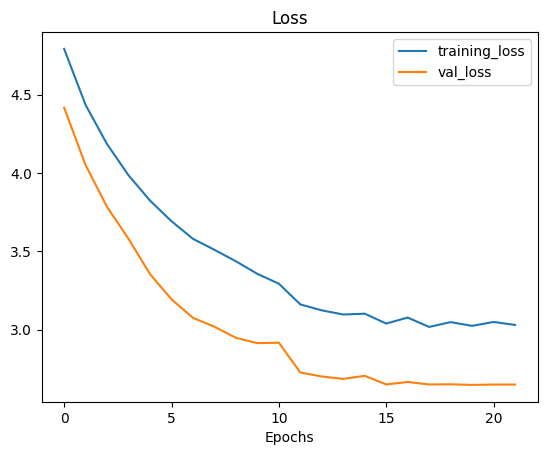

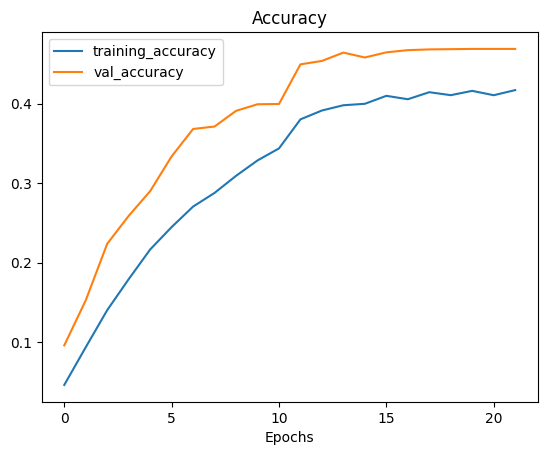

In [ ]:
save_model_and_history(model_1, history_1.history, model_1.name, mainDirectory + "/Model1/")
model_loaded, hystory_loaded = load_model_and_history(model_1.name, mainDirectory + "/Model1/")
plot_loss_curves(hystory_loaded)
predicted = test_model(model_loaded, test_data, test_dataset)

# Model 2 CNN + GRU

In [ ]:
base, _ = load_model_and_history(model_1.name, mainDirectory + "/Model1/")


input = base.layers[0].output
x = base.layers[-3].output
x = MaxPool2D()(x)


print(x.shape)
x = tf.transpose(x, perm=[0, 2, 1, 3])
print(x.shape)
x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
print(x.shape)

x = Bidirectional(GRU(128,return_sequences=True))(x)
x = Bidirectional(GRU(128,return_sequences=True))(x)
x = Dropout(0.5)(x)
x = LayerNormalization()(x)
x = Bidirectional(GRU(128,return_sequences=False))(x)
# x = tf.keras.layers.GlobalAveragePooling1D()(x)
output=Dense(264)(x)

model_2_CNN2GRU = tf.keras.Model(input, output, name="CONV_2_GRU")
model_2_CNN2GRU.summary()

(None, 8, 12, 64)
(None, 12, 8, 64)
(None, 12, 512)
Model: "CONV_2_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320000)]          0         
                                                                 
 mel_spectrogram (MelSpectro  (None, 128, 384, 3)      0         
 gram)                                                           
                                                                 
 z_score_min_max (ZScoreMinM  (None, 128, 384, 3)      0         
 ax)                                                             
                                                                 
 conv2d (Conv2D)             (None, 64, 192, 32)       34880     
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 96, 32)        371744    
                                                                 
 max

In [ ]:
model_2_CNN2GRU.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
history_2 = model_2_CNN2GRU.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=30,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "CONV_1"), # track the model training logs
                                create_model_checkpoint(model_2_CNN2GRU.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2) ,
                                create_ReduceLROnPlateau()])

Saving TensorBoard log files to: training_logs/CONV_1/20230616-150506
Epoch 1/30
1105/1105 [==============================] - ETA: 0s - loss: 3.7217 - accuracy: 0.2613

1105/1105 [==============================] - 1314s 1s/step - loss: 3.7217 - accuracy: 0.2613 - val_loss: 2.9493 - val_accuracy: 0.4057 - lr: 5.0000e-04
Epoch 2/30
1105/1105 [==============================] - ETA: 0s - loss: 3.2551 - accuracy: 0.3519

1105/1105 [==============================] - 402s 363ms/step - loss: 3.2551 - accuracy: 0.3519 - val_loss: 2.7331 - val_accuracy: 0.4355 - lr: 5.0000e-04
Epoch 3/30
1105/1105 [==============================] - ETA: 0s - loss: 3.1058 - accuracy: 0.3906

1105/1105 [==============================] - 409s 370ms/step - loss: 3.1058 - accuracy: 0.3906 - val_loss: 2.6716 - val_accuracy: 0.4620 - lr: 5.0000e-04
Epoch 4/30
1105/1105 [==============================] - ETA: 0s - loss: 2.9889 - accuracy: 0.4173
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1105/1105 [==============================] - 366s 331ms/step - loss: 2.9889 - accuracy: 0.4173 - val_loss: 2.7243 - val_accuracy: 0.4503 - lr: 5.0000e-04
Epoch 5/30
1105/1105 [==============================] - ETA: 0s - loss: 2.7591 - accuracy: 0.4769

1105/1105 [==============================] - 416s 377ms/step - loss: 2.7591 - accuracy: 0.4769 - val_loss: 2.5284 - val_accuracy: 0.4962 - lr: 1.0000e-04
Epoch 6/30
1105/1105 [==============================] - ETA: 0s - loss: 2.6943 - accuracy: 0.4916
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
1105/1105 [==============================] - 379s 343ms/step - loss: 2.6943 - accuracy: 0.4916 - val_loss: 2.5296 - val_accuracy: 0.4971 - lr: 1.0000e-04
Epoch 7/30
1105/1105 [==============================] - ETA: 0s - loss: 2.6291 - accuracy: 0.5131

1105/1105 [==============================] - 406s 367ms/step - loss: 2.6291 - accuracy: 0.5131 - val_loss: 2.5088 - val_accuracy: 0.5032 - lr: 2.0000e-05
Epoch 8/30
1105/1105 [==============================] - ETA: 0s - loss: 2.6129 - accuracy: 0.5126

1105/1105 [==============================] - 408s 369ms/step - loss: 2.6129 - accuracy: 0.5126 - val_loss: 2.5018 - val_accuracy: 0.5017 - lr: 2.0000e-05
Epoch 9/30
1105/1105 [==============================] - ETA: 0s - loss: 2.6240 - accuracy: 0.5127
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
1105/1105 [==============================] - 374s 338ms/step - loss: 2.6240 - accuracy: 0.5127 - val_loss: 2.5078 - val_accuracy: 0.5029 - lr: 2.0000e-05
Epoch 10/30
1105/1105 [==============================] - ETA: 0s - loss: 2.5951 - accuracy: 0.5207
Epoch 10: ReduceLROnPlateau reducing learning rate to 8.000000889296644e-07.
1105/1105 [==============================] - 372s 337ms/step - loss: 2.5951 - accuracy: 0.5207 - val_loss: 2.5033 - val_accuracy: 0.5042 - lr: 4.0000e-06


Index 0
Index 1000
Index 2000
Index 3000
Using average probability
    accuracy  precision    recall        f1
0  57.378087    0.58278  0.573781  0.562279
Top 5 accuracy is:  0.7754908169727676
Classes with most mistakes
                      Name  Mistaken  All  Percent mistaken
21            Barn Swallow        54  105          0.514286
73     Common House-Martin        36   90          0.400000
111            Great Egret        31   53          0.584906
29   Black-backed Puffback        29   35          0.828571
71           Common Bulbul        28   62          0.451613
133           Little Egret        27   79          0.341772
88         Eurasian Hoopoe        26   92          0.282609
95                Garganey        26   29          0.896552
93      Fork-tailed Drongo        23   29          0.793103
183     Red-rumped Swallow        23   48          0.479167
Using max logits
   accuracy  precision    recall        f1
0  55.19316   0.564026  0.551932  0.541157
Top 5 accuracy i

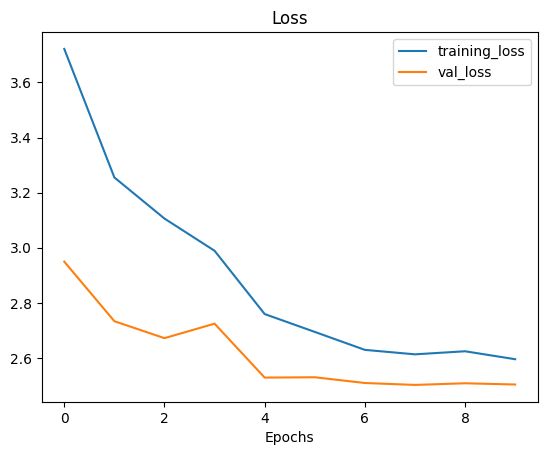

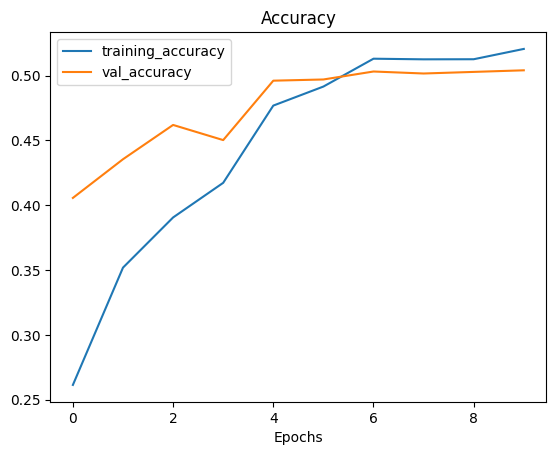

In [ ]:
save_model_and_history(model_2_CNN2GRU, history_2.history, model_2_CNN2GRU.name, mainDirectory + "/Model2/")
model_loaded, hystory_loaded = load_model_and_history(model_2_CNN2GRU.name, mainDirectory + "/Model2/")
plot_loss_curves(hystory_loaded)
predicted = test_model(model_loaded, test_data, test_dataset)

# Model 3 CNN + GRU 2 + TimeFreqMask

In [ ]:
input=Input(shape=(320000))

x = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                    n_fft=CFG.nfft,
                                    hop_length=CFG.hop_length,
                                    sr=CFG.sample_rate,
                                    ref=1.0,
                                    out_channels=CFG.out_channels)(input)

x = tfe.layers.ZScoreMinMax()(x)

x = tfe.layers.TimeFreqMask(freq_mask_prob=CFG.freq_mask_prob,
                              num_freq_masks=CFG.num_freq_masks,
                              freq_mask_param=CFG.freq_mask_param,
                              time_mask_prob=CFG.time_mask_prob,
                              num_time_masks=CFG.num_time_masks,
                              time_mask_param=CFG.time_mask_param,
                              time_last=False)(x)

x = Conv2D(32,kernel_size=[11,33], strides=[2,2],padding='same', activation='relu')(x)
x = Conv2D(32,kernel_size=[11,33], strides=[2,2],padding='same', activation='relu')(x)
x = MaxPool2D()(x)

x = Conv2D(32,kernel_size=[11,33], dilation_rate = [2, 2], padding='same', activation='relu')(x)
x = Conv2D(64,kernel_size=[11,33], strides=[1,2], padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)

print(x.shape)
x = tf.transpose(x, perm=[0, 2, 1, 3])
print(x.shape)
x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
print(x.shape)

x = Bidirectional(GRU(128,return_sequences=True))(x)
x = Bidirectional(GRU(128,return_sequences=True))(x)
x = Dropout(0.5)(x)
x = LayerNormalization()(x)
x = Bidirectional(GRU(128,return_sequences=False))(x)
output=Dense(264)(x)

model_3_CNN2GRU = tf.keras.Model(input, output, name="CONV_TO_GRU_3")
model_3_CNN2GRU.summary()

In [ ]:
model_3_CNN2GRU.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
history_3 = model_3_CNN2GRU.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=40,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "CONV_1"), # track the model training logs
                                create_model_checkpoint(model_3_CNN2GRU.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2) ,
                                create_ReduceLROnPlateau()])

Saving TensorBoard log files to: training_logs/CONV_1/20230616-165749
Epoch 1/40
1105/1105 [==============================] - ETA: 0s - loss: 4.8540 - accuracy: 0.0313

1105/1105 [==============================] - 1459s 1s/step - loss: 4.8540 - accuracy: 0.0313 - val_loss: 4.6748 - val_accuracy: 0.0345 - lr: 0.0010
Epoch 2/40
1105/1105 [==============================] - ETA: 0s - loss: 4.7614 - accuracy: 0.0342

1105/1105 [==============================] - 491s 444ms/step - loss: 4.7614 - accuracy: 0.0342 - val_loss: 4.5633 - val_accuracy: 0.0532 - lr: 0.0010
Epoch 3/40
1105/1105 [==============================] - ETA: 0s - loss: 4.6090 - accuracy: 0.0605

1105/1105 [==============================] - 496s 449ms/step - loss: 4.6090 - accuracy: 0.0605 - val_loss: 4.2015 - val_accuracy: 0.1305 - lr: 0.0010
Epoch 4/40
 717/1105 [==================>...........] - ETA: 2:32 - loss: 4.4142 - accuracy: 0.0990

In [ ]:
# save_model_and_history(model_3_CNN2GRU, history_3.history, model_3_CNN2GRU.name, mainDirectory + "/Model3/")
model_loaded, hystory_loaded = load_model_and_history(model_3_CNN2GRU.name, mainDirectory + "/Model3/")
plot_loss_curves(hystory_loaded)
# predicted = test_model(model_loaded, test_data, test_dataset)

NameError: ignored

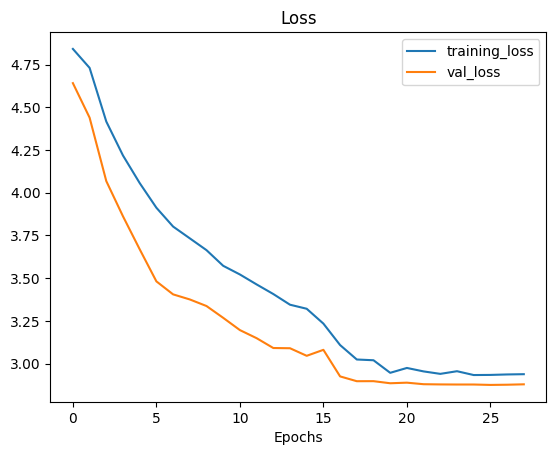

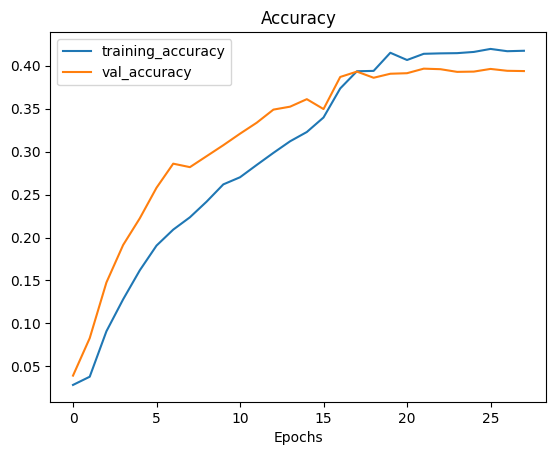

In [ ]:
model_loaded, hystory_loaded = load_model_and_history(model_3_CNN2GRU.name, mainDirectory + "/Model3/")
plot_loss_curves(hystory_loaded)
# predicted = test_model(model_loaded, test_data, test_dataset)

# Model 4 CNN + LSTM

LSTM whthout dropout also showed a performance improvement in ither rest that were lost.

In [ ]:
input=Input(shape=(320000))

x = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                    n_fft=CFG.nfft,
                                    hop_length=CFG.hop_length,
                                    sr=CFG.sample_rate,
                                    ref=1.0,
                                    out_channels=CFG.out_channels)(input)


x = Normalization()(x)
x = Conv2D(32,kernel_size=[11,41], strides=[2,2], padding='same', activation='relu')(x)
x = LayerNormalization()(x)
x = Conv2D(64,kernel_size=[11,21], strides=[1,2], padding='same', activation='relu')(x)
x = LayerNormalization()(x)

print(x.shape)
x = tf.transpose(x, perm=[0, 2, 1, 3])
print(x.shape)
x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
print(x.shape)

x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = Dropout(0.5)(x)
x = LayerNormalization()(x)
x = Bidirectional(LSTM(128,return_sequences=False))(x)
output=Dense(264)(x)

model_4_CNN2LSTM = tf.keras.Model(input, output, name="CONV_TO_LSTM_1")
model_4_CNN2LSTM.summary()

(None, 64, 96, 64)
(None, 96, 64, 64)
(None, 96, 4096)
Model: "CONV_TO_LSTM_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 320000)]          0         
                                                                 
 mel_spectrogram (MelSpectro  (None, 128, 384, 3)      0         
 gram)                                                           
                                                                 
 normalization_1 (Normalizat  (None, 128, 384, 3)      7         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 192, 32)       43328     
                                                                 
 layer_normalization_3 (Laye  (None, 64, 192, 32)      64        
 rNormalization)                                               

In [ ]:
model_4_CNN2LSTM.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
history_4 = model_4_CNN2LSTM.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=25,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "model_4_CNN2LSTM"), # track the model training logs
                                create_model_checkpoint(model_4_CNN2LSTM.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2) ,
                                create_ReduceLROnPlateau(factor=0.1)])

Saving TensorBoard log files to: training_logs/model_4_CNN2LSTM/20230616-224909
Epoch 1/30
1105/1105 [==============================] - ETA: 0s - loss: 4.8049 - accuracy: 0.0310

1105/1105 [==============================] - 518s 454ms/step - loss: 4.8049 - accuracy: 0.0310 - val_loss: 4.6345 - val_accuracy: 0.0403 - lr: 0.0010
Epoch 2/30
1105/1105 [==============================] - ETA: 0s - loss: 4.7338 - accuracy: 0.0367

1105/1105 [==============================] - 494s 447ms/step - loss: 4.7338 - accuracy: 0.0367 - val_loss: 4.6309 - val_accuracy: 0.0363 - lr: 0.0010
Epoch 3/30
1105/1105 [==============================] - ETA: 0s - loss: 4.6804 - accuracy: 0.0454

1105/1105 [==============================] - 505s 457ms/step - loss: 4.6804 - accuracy: 0.0454 - val_loss: 4.4766 - val_accuracy: 0.0699 - lr: 0.0010
Epoch 4/30
1105/1105 [==============================] - ETA: 0s - loss: 4.5665 - accuracy: 0.0674

1105/1105 [==============================] - 488s 442ms/step - loss: 4.5665 - accuracy: 0.0674 - val_loss: 4.3437 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 5/30
1105/1105 [==============================] - ETA: 0s - loss: 4.4628 - accuracy: 0.0831

1105/1105 [==============================] - 507s 458ms/step - loss: 4.4628 - accuracy: 0.0831 - val_loss: 4.2679 - val_accuracy: 0.1108 - lr: 0.0010
Epoch 6/30
1105/1105 [==============================] - ETA: 0s - loss: 4.3782 - accuracy: 0.0933

1105/1105 [==============================] - 503s 455ms/step - loss: 4.3782 - accuracy: 0.0933 - val_loss: 4.1839 - val_accuracy: 0.1247 - lr: 0.0010
Epoch 7/30
1105/1105 [==============================] - ETA: 0s - loss: 4.2888 - accuracy: 0.1142

1105/1105 [==============================] - 496s 449ms/step - loss: 4.2888 - accuracy: 0.1142 - val_loss: 4.1359 - val_accuracy: 0.1487 - lr: 0.0010
Epoch 8/30
1105/1105 [==============================] - ETA: 0s - loss: 4.2166 - accuracy: 0.1204

1105/1105 [==============================] - 499s 451ms/step - loss: 4.2166 - accuracy: 0.1204 - val_loss: 4.0657 - val_accuracy: 0.1511 - lr: 0.0010
Epoch 9/30
1105/1105 [==============================] - ETA: 0s - loss: 4.1501 - accuracy: 0.1343

1105/1105 [==============================] - 501s 453ms/step - loss: 4.1501 - accuracy: 0.1343 - val_loss: 3.9828 - val_accuracy: 0.1631 - lr: 0.0010
Epoch 10/30
1105/1105 [==============================] - ETA: 0s - loss: 4.0659 - accuracy: 0.1483

1105/1105 [==============================] - 496s 449ms/step - loss: 4.0659 - accuracy: 0.1483 - val_loss: 3.9102 - val_accuracy: 0.1764 - lr: 0.0010
Epoch 11/30
1105/1105 [==============================] - ETA: 0s - loss: 3.9810 - accuracy: 0.1667

1105/1105 [==============================] - 500s 452ms/step - loss: 3.9810 - accuracy: 0.1667 - val_loss: 3.8429 - val_accuracy: 0.1951 - lr: 0.0010
Epoch 12/30
1105/1105 [==============================] - ETA: 0s - loss: 3.9127 - accuracy: 0.1812

1105/1105 [==============================] - 502s 454ms/step - loss: 3.9127 - accuracy: 0.1812 - val_loss: 3.8100 - val_accuracy: 0.2050 - lr: 0.0010
Epoch 13/30
1105/1105 [==============================] - ETA: 0s - loss: 3.8464 - accuracy: 0.1914

1105/1105 [==============================] - 491s 445ms/step - loss: 3.8464 - accuracy: 0.1914 - val_loss: 3.7044 - val_accuracy: 0.2305 - lr: 0.0010
Epoch 14/30
1105/1105 [==============================] - ETA: 0s - loss: 3.7621 - accuracy: 0.2120

1105/1105 [==============================] - 529s 479ms/step - loss: 3.7621 - accuracy: 0.2120 - val_loss: 3.6809 - val_accuracy: 0.2364 - lr: 0.0010
Epoch 15/30
1105/1105 [==============================] - ETA: 0s - loss: 3.6999 - accuracy: 0.2250

1105/1105 [==============================] - 494s 447ms/step - loss: 3.6999 - accuracy: 0.2250 - val_loss: 3.6338 - val_accuracy: 0.2432 - lr: 0.0010
Epoch 16/30
1105/1105 [==============================] - ETA: 0s - loss: 3.6133 - accuracy: 0.2420

1105/1105 [==============================] - 489s 443ms/step - loss: 3.6133 - accuracy: 0.2420 - val_loss: 3.5772 - val_accuracy: 0.2622 - lr: 0.0010
Epoch 17/30
1105/1105 [==============================] - ETA: 0s - loss: 3.5760 - accuracy: 0.2535
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1105/1105 [==============================] - 455s 412ms/step - loss: 3.5760 - accuracy: 0.2535 - val_loss: 3.5826 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 18/30
1105/1105 [==============================] - ETA: 0s - loss: 3.4187 - accuracy: 0.2854

1105/1105 [==============================] - 488s 442ms/step - loss: 3.4187 - accuracy: 0.2854 - val_loss: 3.4816 - val_accuracy: 0.2776 - lr: 1.0000e-04
Epoch 19/30
1105/1105 [==============================] - ETA: 0s - loss: 3.3655 - accuracy: 0.3006

1105/1105 [==============================] - 496s 449ms/step - loss: 3.3655 - accuracy: 0.3006 - val_loss: 3.4613 - val_accuracy: 0.2859 - lr: 1.0000e-04
Epoch 20/30
1105/1105 [==============================] - ETA: 0s - loss: 3.3214 - accuracy: 0.3100

1105/1105 [==============================] - 497s 450ms/step - loss: 3.3214 - accuracy: 0.3100 - val_loss: 3.4468 - val_accuracy: 0.2881 - lr: 1.0000e-04
Epoch 21/30
1105/1105 [==============================] - ETA: 0s - loss: 3.2986 - accuracy: 0.3183

1105/1105 [==============================] - 498s 450ms/step - loss: 3.2986 - accuracy: 0.3183 - val_loss: 3.4460 - val_accuracy: 0.2930 - lr: 1.0000e-04
Epoch 22/30
1105/1105 [==============================] - ETA: 0s - loss: 3.2916 - accuracy: 0.3171

1105/1105 [==============================] - 484s 438ms/step - loss: 3.2916 - accuracy: 0.3171 - val_loss: 3.4342 - val_accuracy: 0.2942 - lr: 1.0000e-04
Epoch 23/30
1105/1105 [==============================] - ETA: 0s - loss: 3.2685 - accuracy: 0.3248

1105/1105 [==============================] - 495s 448ms/step - loss: 3.2685 - accuracy: 0.3248 - val_loss: 3.4181 - val_accuracy: 0.2942 - lr: 1.0000e-04
Epoch 24/30
1105/1105 [==============================] - ETA: 0s - loss: 3.2545 - accuracy: 0.3300

1105/1105 [==============================] - 495s 448ms/step - loss: 3.2545 - accuracy: 0.3300 - val_loss: 3.4162 - val_accuracy: 0.3001 - lr: 1.0000e-04
Epoch 25/30
1105/1105 [==============================] - ETA: 0s - loss: 3.2148 - accuracy: 0.3352

1105/1105 [==============================] - 497s 449ms/step - loss: 3.2148 - accuracy: 0.3352 - val_loss: 3.4142 - val_accuracy: 0.2952 - lr: 1.0000e-04
Epoch 26/30
1105/1105 [==============================] - ETA: 0s - loss: 3.2000 - accuracy: 0.3400

1105/1105 [==============================] - 489s 442ms/step - loss: 3.2000 - accuracy: 0.3400 - val_loss: 3.3977 - val_accuracy: 0.3004 - lr: 1.0000e-04
Epoch 27/30
1105/1105 [==============================] - ETA: 0s - loss: 3.1931 - accuracy: 0.3410
Epoch 27: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1105/1105 [==============================] - 458s 414ms/step - loss: 3.1931 - accuracy: 0.3410 - val_loss: 3.4048 - val_accuracy: 0.3016 - lr: 1.0000e-04
Epoch 28/30
1105/1105 [==============================] - ETA: 0s - loss: 3.1817 - accuracy: 0.3458
Epoch 28: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1105/1105 [==============================] - 466s 422ms/step - loss: 3.1817 - accuracy: 0.3458 - val_loss: 3.3991 - val_accuracy: 0.3038 - lr: 1.0000e-05


Index 0
Index 1000
Index 2000
Index 3000
Using average probability
    accuracy  precision    recall        f1
0  34.578847    0.30756  0.345788  0.302591
Top 5 accuracy is:  0.597530082330589
Classes with most mistakes
                        Name  Mistaken  All  Percent mistaken
21              Barn Swallow        64  105          0.609524
247           Wood Sandpiper        57  102          0.558824
73       Common House-Martin        54   90          0.600000
25                Black Kite        49   55          0.890909
74          Common Sandpiper        44  105          0.419048
111              Great Egret        39   53          0.735849
71             Common Bulbul        37   62          0.596774
103  Gray-backed Camaroptera        36   50          0.720000
88           Eurasian Hoopoe        35   92          0.380435
29     Black-backed Puffback        35   35          1.000000
Using max logits
    accuracy  precision    recall       f1
0  32.615579   0.288282  0.326156  0.2

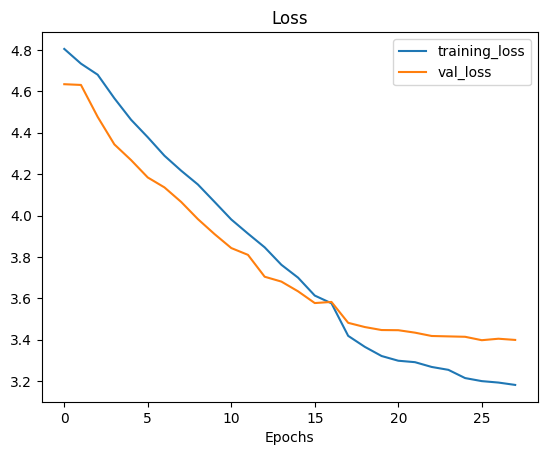

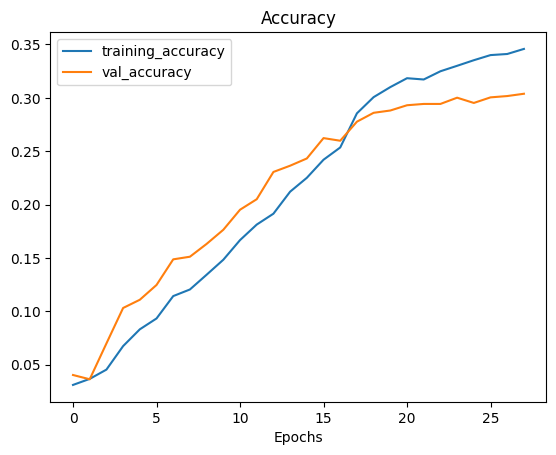

In [ ]:
save_model_and_history(model_4_CNN2LSTM, history_4.history, model_4_CNN2LSTM.name, mainDirectory + "/Model4/")
model_loaded, hystory_loaded = load_model_and_history(model_4_CNN2LSTM.name, mainDirectory + "/Model4/")
plot_loss_curves(hystory_loaded)
predicted = test_model(model_loaded, test_data, test_dataset)

# Model 5 CNN + GRU V2

In [ ]:
input=Input(shape=(320000))

x = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                    n_fft=CFG.nfft,
                                    hop_length=CFG.hop_length,
                                    sr=CFG.sample_rate,
                                    ref=1.0,
                                    out_channels=CFG.out_channels)(input)

x = Normalization()(x)
x = Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x = LayerNormalization()(x)
x = Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x = LayerNormalization()(x)

print(x.shape)
x = tf.transpose(x, perm=[0, 2, 1, 3])
print(x.shape)
x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
print(x.shape)

x = Bidirectional(GRU(128,return_sequences=True))(x)
x = Bidirectional(GRU(128,return_sequences=True))(x)
x = Dropout(0.5)(x)
x = LayerNormalization()(x)
x = Bidirectional(GRU(128,return_sequences=False))(x)
output = Dense(264)(x)

model_5_CNN2GRU_V2 = tf.keras.Model(input, output, name="CONV_TO_GRU_3_V2")
model_5_CNN2GRU_V2.summary()

(None, 64, 96, 64)
(None, 96, 64, 64)
(None, 96, 4096)
Model: "CONV_TO_GRU_3_V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 320000)]          0         
                                                                 
 mel_spectrogram (MelSpectro  (None, 128, 384, 3)      0         
 gram)                                                           
                                                                 
 normalization_2 (Normalizat  (None, 128, 384, 3)      7         
 ion)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 192, 32)       43328     
                                                                 
 layer_normalization_6 (Laye  (None, 64, 192, 32)      64        
 rNormalization)                                             

In [ ]:
model_5_CNN2GRU_V2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
history_5 = model_5_CNN2GRU_V2.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=25,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "model_5_CNN2GRU_V2"), # track the model training logs
                                create_model_checkpoint(model_5_CNN2GRU_V2.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2) ,
                                create_ReduceLROnPlateau(factor=0.1)])

Saving TensorBoard log files to: training_logs/model_5_CNN2GRU_V2/20230617-163246
Epoch 1/25
1105/1105 [==============================] - ETA: 0s - loss: 4.8123 - accuracy: 0.0388

1105/1105 [==============================] - 1414s 1s/step - loss: 4.8123 - accuracy: 0.0388 - val_loss: 4.4864 - val_accuracy: 0.0757 - lr: 1.0000e-04
Epoch 2/25
1105/1105 [==============================] - ETA: 0s - loss: 4.4710 - accuracy: 0.0978

1105/1105 [==============================] - 464s 420ms/step - loss: 4.4710 - accuracy: 0.0978 - val_loss: 4.0700 - val_accuracy: 0.1548 - lr: 1.0000e-04
Epoch 3/25
1105/1105 [==============================] - ETA: 0s - loss: 4.1566 - accuracy: 0.1558

1105/1105 [==============================] - 456s 413ms/step - loss: 4.1566 - accuracy: 0.1558 - val_loss: 3.8074 - val_accuracy: 0.2151 - lr: 1.0000e-04
Epoch 4/25
1105/1105 [==============================] - ETA: 0s - loss: 3.8857 - accuracy: 0.2077

1105/1105 [==============================] - 455s 412ms/step - loss: 3.8857 - accuracy: 0.2077 - val_loss: 3.4716 - val_accuracy: 0.2832 - lr: 1.0000e-04
Epoch 5/25
1105/1105 [==============================] - ETA: 0s - loss: 3.6430 - accuracy: 0.2564

1105/1105 [==============================] - 462s 418ms/step - loss: 3.6430 - accuracy: 0.2564 - val_loss: 3.2417 - val_accuracy: 0.3213 - lr: 1.0000e-04
Epoch 6/25
1105/1105 [==============================] - ETA: 0s - loss: 3.4416 - accuracy: 0.3015

1105/1105 [==============================] - 472s 427ms/step - loss: 3.4416 - accuracy: 0.3015 - val_loss: 3.1183 - val_accuracy: 0.3472 - lr: 1.0000e-04
Epoch 7/25
1105/1105 [==============================] - ETA: 0s - loss: 3.2495 - accuracy: 0.3481

1105/1105 [==============================] - 461s 417ms/step - loss: 3.2495 - accuracy: 0.3481 - val_loss: 2.9869 - val_accuracy: 0.3801 - lr: 1.0000e-04
Epoch 8/25
1105/1105 [==============================] - ETA: 0s - loss: 3.0897 - accuracy: 0.3859

1105/1105 [==============================] - 463s 419ms/step - loss: 3.0897 - accuracy: 0.3859 - val_loss: 2.9524 - val_accuracy: 0.3937 - lr: 1.0000e-04
Epoch 9/25
1105/1105 [==============================] - ETA: 0s - loss: 2.9596 - accuracy: 0.4226

1105/1105 [==============================] - 457s 413ms/step - loss: 2.9596 - accuracy: 0.4226 - val_loss: 2.7990 - val_accuracy: 0.4291 - lr: 1.0000e-04
Epoch 10/25
1105/1105 [==============================] - ETA: 0s - loss: 2.8135 - accuracy: 0.4632

1105/1105 [==============================] - 456s 413ms/step - loss: 2.8135 - accuracy: 0.4632 - val_loss: 2.7143 - val_accuracy: 0.4466 - lr: 1.0000e-04
Epoch 11/25
1105/1105 [==============================] - ETA: 0s - loss: 2.6863 - accuracy: 0.4985
Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1105/1105 [==============================] - 423s 383ms/step - loss: 2.6863 - accuracy: 0.4985 - val_loss: 2.7160 - val_accuracy: 0.4475 - lr: 1.0000e-04
Epoch 12/25
1105/1105 [==============================] - ETA: 0s - loss: 2.5133 - accuracy: 0.5407

1105/1105 [==============================] - 456s 413ms/step - loss: 2.5133 - accuracy: 0.5407 - val_loss: 2.6232 - val_accuracy: 0.4743 - lr: 1.0000e-05
Epoch 13/25
1105/1105 [==============================] - ETA: 0s - loss: 2.4559 - accuracy: 0.5623

1105/1105 [==============================] - 450s 408ms/step - loss: 2.4559 - accuracy: 0.5623 - val_loss: 2.5949 - val_accuracy: 0.4783 - lr: 1.0000e-05
Epoch 14/25
1105/1105 [==============================] - ETA: 0s - loss: 2.4309 - accuracy: 0.5650

1105/1105 [==============================] - 455s 412ms/step - loss: 2.4309 - accuracy: 0.5650 - val_loss: 2.5905 - val_accuracy: 0.4811 - lr: 1.0000e-05
Epoch 15/25
1105/1105 [==============================] - ETA: 0s - loss: 2.4327 - accuracy: 0.5697
Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
1105/1105 [==============================] - 427s 386ms/step - loss: 2.4327 - accuracy: 0.5697 - val_loss: 2.5906 - val_accuracy: 0.4845 - lr: 1.0000e-05
Epoch 16/25
1105/1105 [==============================] - ETA: 0s - loss: 2.3845 - accuracy: 0.5792

1105/1105 [==============================] - 458s 415ms/step - loss: 2.3845 - accuracy: 0.5792 - val_loss: 2.5811 - val_accuracy: 0.4851 - lr: 1.0000e-06
Epoch 17/25
1105/1105 [==============================] - ETA: 0s - loss: 2.4147 - accuracy: 0.5764

1105/1105 [==============================] - 463s 419ms/step - loss: 2.4147 - accuracy: 0.5764 - val_loss: 2.5780 - val_accuracy: 0.4851 - lr: 1.0000e-06
Epoch 18/25
1105/1105 [==============================] - ETA: 0s - loss: 2.3584 - accuracy: 0.5843

1105/1105 [==============================] - 456s 413ms/step - loss: 2.3584 - accuracy: 0.5843 - val_loss: 2.5769 - val_accuracy: 0.4869 - lr: 1.0000e-06
Epoch 19/25
1105/1105 [==============================] - ETA: 0s - loss: 2.3794 - accuracy: 0.5813

1105/1105 [==============================] - 458s 414ms/step - loss: 2.3794 - accuracy: 0.5813 - val_loss: 2.5763 - val_accuracy: 0.4866 - lr: 1.0000e-06
Epoch 20/25
1105/1105 [==============================] - ETA: 0s - loss: 2.3590 - accuracy: 0.5853

1105/1105 [==============================] - 470s 425ms/step - loss: 2.3590 - accuracy: 0.5853 - val_loss: 2.5761 - val_accuracy: 0.4863 - lr: 1.0000e-06
Epoch 21/25
1105/1105 [==============================] - ETA: 0s - loss: 2.3843 - accuracy: 0.5787

1105/1105 [==============================] - 463s 419ms/step - loss: 2.3843 - accuracy: 0.5787 - val_loss: 2.5742 - val_accuracy: 0.4897 - lr: 1.0000e-06
Epoch 22/25
1105/1105 [==============================] - ETA: 0s - loss: 2.3686 - accuracy: 0.5846

1105/1105 [==============================] - 455s 412ms/step - loss: 2.3686 - accuracy: 0.5846 - val_loss: 2.5728 - val_accuracy: 0.4882 - lr: 1.0000e-06
Epoch 23/25
1105/1105 [==============================] - ETA: 0s - loss: 2.3676 - accuracy: 0.5810
Epoch 23: ReduceLROnPlateau reducing learning rate to 1e-07.
1105/1105 [==============================] - 425s 385ms/step - loss: 2.3676 - accuracy: 0.5810 - val_loss: 2.5729 - val_accuracy: 0.4875 - lr: 1.0000e-06
Epoch 24/25
1105/1105 [==============================] - 424s 384ms/step - loss: 2.3815 - accuracy: 0.5826 - val_loss: 2.5728 - val_accuracy: 0.4875 - lr: 1.0000e-07


Index 0
Index 1000
Index 2000
Index 3000
Using average probability
    accuracy  precision    recall        f1
0  53.989867   0.526406  0.539899  0.511598
Top 5 accuracy is:  0.7644078530715643
Classes with most mistakes
                      Name  Mistaken  All  Percent mistaken
21            Barn Swallow        52  105          0.495238
71           Common Bulbul        31   62          0.500000
73     Common House-Martin        31   90          0.344444
111            Great Egret        29   53          0.547170
88         Eurasian Hoopoe        28   92          0.304348
29   Black-backed Puffback        27   35          0.771429
247         Wood Sandpiper        27  102          0.264706
25              Black Kite        25   55          0.454545
133           Little Egret        23   79          0.291139
95                Garganey        22   29          0.758621
Using max logits
    accuracy  precision    recall        f1
0  53.863205   0.516372  0.538632  0.508891
Top 5 accuracy

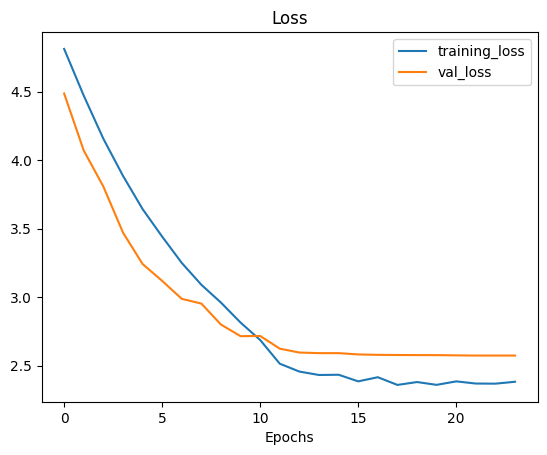

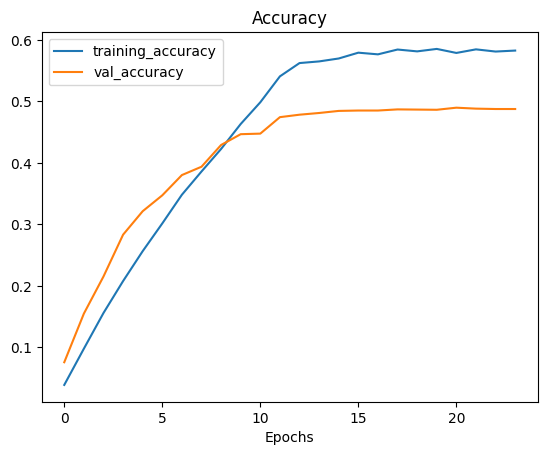

In [ ]:
save_model_and_history(model_5_CNN2GRU_V2, history_5.history, model_5_CNN2GRU_V2.name, mainDirectory + "/Model5/")
model_loaded, hystory_loaded = load_model_and_history(model_5_CNN2GRU_V2.name, mainDirectory + "/Model5/")
plot_loss_curves(hystory_loaded)
predicted = test_model(model_loaded, test_data, test_dataset)

# Model 6 efficient net

In [ ]:
!pip install -U git+https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-kgmu1ss4
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/efficientnet /tmp/pip-req-build-kgmu1ss4
  Resolved https://github.com/qubvel/efficientnet to commit f7f3e736c113b872caf53dae9fbbda996a8eb87d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18430 sha256=2728c6a8130a067592d8d674dbb66c7c565be4b8438b98f01d1327fc0c6b5ede
  Stored in directory: /tmp/pip-ephem-wheel-cache-o__s9fpk/wheels/bb/0f/38/154505705a0899276d49f521ee621a61bc2a8767026220f751
Successfully built efficientnet


In [ ]:
input=Input(shape=(320000))

x = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                    n_fft=CFG.nfft,
                                    hop_length=CFG.hop_length,
                                    sr=CFG.sample_rate,
                                    ref=1.0,
                                    out_channels=CFG.out_channels)(input)

# x = tfe.layers.ZScoreMinMax()(x)

# x = tfe.layers.TimeFreqMask(freq_mask_prob=CFG.freq_mask_prob,
#                               num_freq_masks=CFG.num_freq_masks,
#                               freq_mask_param=CFG.freq_mask_param,
#                               time_mask_prob=CFG.time_mask_prob,
#                               num_time_masks=CFG.num_time_masks,
#                               time_mask_param=CFG.time_mask_param,
#                               time_last=False)(x)

# base = getattr(efn, 'EfficientNetB1')(input_shape=(128, 384, 3),
#                                         include_top=False,
#                                         weights ='imagenet')
base = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(input_shape=(128, 384, 3),
                                                              include_top=False,
                                                              weights ='imagenet',
                                                              include_preprocessing = True)

base.trainable = True
# make_trainable(base, False)
make_trainable(base, True)

x = tfe.layers.ZScoreMinMax()(x) * 255
# x = Normalization()(x)
x = base(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output=Dense(264)(x)

model_6_EFFNet = tf.keras.Model(input, output, name="EFF_NET_1")
model_6_EFFNet.summary()

28456008/28456008 [==============================] - 3s 0us/step
Model: "EFF_NET_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320000)]          0         
                                                                 
 mel_spectrogram (MelSpectro  (None, 128, 384, 3)      0         
 gram)                                                           
                                                                 
 z_score_min_max (ZScoreMinM  (None, 128, 384, 3)      0         
 ax)                                                             
                                                                 
 tf.math.multiply (TFOpLambd  (None, 128, 384, 3)      0         
 a)                                                              
                                                                 
 efficientnetv2-b1 (Function  (None, 4, 12, 1280)      693

In [ ]:
for layer_number, layer in enumerate(base.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn False
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn False
8 block1a_project_activation True
9 block1b_project_conv True
10 block1b_project_bn False
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn False
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn False
19 block2b_expand_conv True
20 block2b_expand_bn False
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn False
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn False
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn False
31 block2c_drop True
32 block2c_add True
33 block3a_expand_conv True
34 block3a_expand_bn False
35 block3a_expand_activation True
36 block3a_project_conv True
37 block3a_project_bn False
38 b

In [ ]:
model_6_EFFNet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
history_6 = model_6_EFFNet.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=40,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "model_6_EFFNet"), # track the model training logs
                                create_model_checkpoint(model_6_EFFNet.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
                                create_ReduceLROnPlateau(factor=0.2)])

Saving TensorBoard log files to: training_logs/model_6_EFFNet/20230617-085001
Epoch 1/40
1105/1105 [==============================] - ETA: 0s - loss: 4.3055 - accuracy: 0.1612

1105/1105 [==============================] - 1424s 1s/step - loss: 4.3055 - accuracy: 0.1612 - val_loss: 2.8284 - val_accuracy: 0.4435 - lr: 1.0000e-04
Epoch 2/40
1105/1105 [==============================] - ETA: 0s - loss: 3.2806 - accuracy: 0.3724

1105/1105 [==============================] - 443s 401ms/step - loss: 3.2806 - accuracy: 0.3724 - val_loss: 2.2918 - val_accuracy: 0.5586 - lr: 1.0000e-04
Epoch 3/40
1105/1105 [==============================] - ETA: 0s - loss: 2.8582 - accuracy: 0.4712

1105/1105 [==============================] - 465s 421ms/step - loss: 2.8582 - accuracy: 0.4712 - val_loss: 2.0536 - val_accuracy: 0.6239 - lr: 1.0000e-04
Epoch 4/40
1105/1105 [==============================] - ETA: 0s - loss: 2.6195 - accuracy: 0.5219

1105/1105 [==============================] - 497s 450ms/step - loss: 2.6195 - accuracy: 0.5219 - val_loss: 1.8274 - val_accuracy: 0.6719 - lr: 1.0000e-04
Epoch 5/40
1105/1105 [==============================] - ETA: 0s - loss: 2.4341 - accuracy: 0.5623

1105/1105 [==============================] - 506s 458ms/step - loss: 2.4341 - accuracy: 0.5623 - val_loss: 1.7884 - val_accuracy: 0.6910 - lr: 1.0000e-04
Epoch 6/40
1105/1105 [==============================] - ETA: 0s - loss: 2.3098 - accuracy: 0.5899

1105/1105 [==============================] - 512s 464ms/step - loss: 2.3098 - accuracy: 0.5899 - val_loss: 1.7305 - val_accuracy: 0.6938 - lr: 1.0000e-04
Epoch 7/40
1105/1105 [==============================] - ETA: 0s - loss: 2.1962 - accuracy: 0.6182

1105/1105 [==============================] - 504s 456ms/step - loss: 2.1962 - accuracy: 0.6182 - val_loss: 1.6978 - val_accuracy: 0.7002 - lr: 1.0000e-04
Epoch 8/40
1105/1105 [==============================] - ETA: 0s - loss: 2.1152 - accuracy: 0.6352

1105/1105 [==============================] - 512s 463ms/step - loss: 2.1152 - accuracy: 0.6352 - val_loss: 1.6482 - val_accuracy: 0.7184 - lr: 1.0000e-04
Epoch 9/40
1105/1105 [==============================] - ETA: 0s - loss: 2.0541 - accuracy: 0.6525
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1105/1105 [==============================] - 437s 396ms/step - loss: 2.0541 - accuracy: 0.6525 - val_loss: 1.6544 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 10/40
1105/1105 [==============================] - ETA: 0s - loss: 1.9116 - accuracy: 0.6821

1105/1105 [==============================] - 510s 462ms/step - loss: 1.9116 - accuracy: 0.6821 - val_loss: 1.5388 - val_accuracy: 0.7433 - lr: 2.0000e-05
Epoch 11/40
1105/1105 [==============================] - ETA: 0s - loss: 1.8749 - accuracy: 0.6932

1105/1105 [==============================] - 510s 462ms/step - loss: 1.8749 - accuracy: 0.6932 - val_loss: 1.5256 - val_accuracy: 0.7464 - lr: 2.0000e-05
Epoch 12/40
1105/1105 [==============================] - ETA: 0s - loss: 1.8413 - accuracy: 0.7013
Epoch 12: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
1105/1105 [==============================] - 436s 394ms/step - loss: 1.8413 - accuracy: 0.7013 - val_loss: 1.5276 - val_accuracy: 0.7473 - lr: 2.0000e-05
Epoch 13/40
1105/1105 [==============================] - ETA: 0s - loss: 1.8004 - accuracy: 0.7074

1105/1105 [==============================] - 504s 456ms/step - loss: 1.8004 - accuracy: 0.7074 - val_loss: 1.5065 - val_accuracy: 0.7565 - lr: 4.0000e-06
Epoch 14/40
1105/1105 [==============================] - ETA: 0s - loss: 1.7936 - accuracy: 0.7084
Epoch 14: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
1105/1105 [==============================] - 428s 388ms/step - loss: 1.7936 - accuracy: 0.7084 - val_loss: 1.5080 - val_accuracy: 0.7538 - lr: 4.0000e-06
Epoch 15/40
1105/1105 [==============================] - ETA: 0s - loss: 1.8231 - accuracy: 0.7041
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
1105/1105 [==============================] - 442s 400ms/step - loss: 1.8231 - accuracy: 0.7041 - val_loss: 1.5081 - val_accuracy: 0.7556 - lr: 8.0000e-07


Index 0
Index 1000
Index 2000
Index 3000
Using average probability
    accuracy  precision    recall        f1
0  80.145662   0.807863  0.801457  0.797912
Top 5 accuracy is:  0.9297023432552248
Classes with most mistakes
                      Name  Mistaken  All  Percent mistaken
111            Great Egret        21   53          0.396226
133           Little Egret        16   79          0.202532
21            Barn Swallow        15  105          0.142857
88         Eurasian Hoopoe        14   92          0.152174
29   Black-backed Puffback        13   35          0.371429
71           Common Bulbul        13   62          0.209677
183     Red-rumped Swallow        12   48          0.250000
223       Variable Sunbird        12   22          0.545455
220   Tawny-flanked Prinia        12   34          0.352941
93      Fork-tailed Drongo        12   29          0.413793
Using max logits
    accuracy  precision    recall       f1
0  79.575681   0.802862  0.795757  0.79242
Top 5 accuracy i

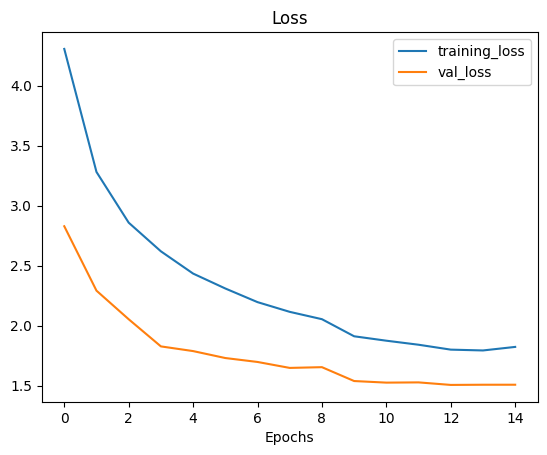

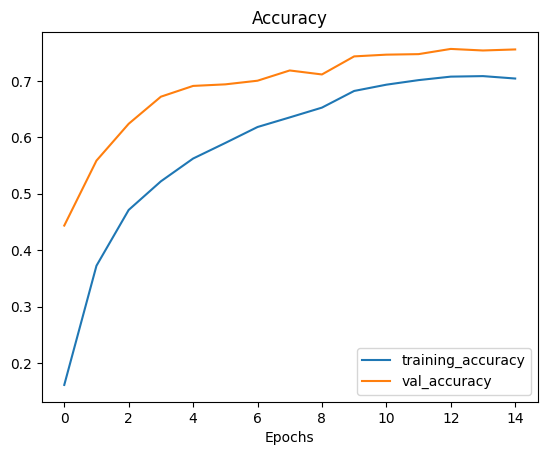

In [ ]:
save_model_and_history(model_6_EFFNet, history_6.history, model_6_EFFNet.name, mainDirectory + "/Model6/")
model_loaded, hystory_loaded = load_model_and_history(model_6_EFFNet.name, mainDirectory + "/Model6/")
plot_loss_curves(hystory_loaded)
predicted = test_model(model_loaded, test_data, test_dataset)

# Model 7 efficient net +  Time Freq Mask

In [ ]:
input=Input(shape=(320000))

x = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                    n_fft=CFG.nfft,
                                    hop_length=CFG.hop_length,
                                    sr=CFG.sample_rate,
                                    ref=1.0,
                                    out_channels=CFG.out_channels)(input)

x = tfe.layers.ZScoreMinMax()(x)

x = tfe.layers.TimeFreqMask(freq_mask_prob=CFG.freq_mask_prob,
                              num_freq_masks=CFG.num_freq_masks,
                              freq_mask_param=CFG.freq_mask_param,
                              time_mask_prob=CFG.time_mask_prob,
                              num_time_masks=CFG.num_time_masks,
                              time_mask_param=CFG.time_mask_param,
                              time_last=False)(x) * 255

# base = getattr(efn, 'EfficientNetB1')(input_shape=(128, 384, 3),
#                                         include_top=False,
#                                         weights ='imagenet')
base = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(input_shape=(128, 384, 3),
                                                              include_top=False,
                                                              weights ='imagenet',
                                                              include_preprocessing = True)

base.trainable = True
# make_trainable(base, False)
make_trainable(base, True)


# x = Normalization()(x)
x = base(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output=Dense(264)(x)

model_7_EFFNet = tf.keras.Model(input, output, name="EFF_NET_2")
model_7_EFFNet.summary()

28456008/28456008 [==============================] - 0s 0us/step
Model: "EFF_NET_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320000)]          0         
                                                                 
 mel_spectrogram (MelSpectro  (None, 128, 384, 3)      0         
 gram)                                                           
                                                                 
 z_score_min_max (ZScoreMinM  (None, 128, 384, 3)      0         
 ax)                                                             
                                                                 
 time_freq_mask (TimeFreqMas  (None, 128, 384, 3)      0         
 k)                                                              
                                                                 
 tf.math.multiply (TFOpLambd  (None, 128, 384, 3)      0  

In [ ]:
for layer_number, layer in enumerate(base.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn False
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn False
8 block1a_project_activation True
9 block1b_project_conv True
10 block1b_project_bn False
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn False
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn False
19 block2b_expand_conv True
20 block2b_expand_bn False
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn False
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn False
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn False
31 block2c_drop True
32 block2c_add True
33 block3a_expand_conv True
34 block3a_expand_bn False
35 block3a_expand_activation True
36 block3a_project_conv True
37 block3a_project_bn False
38 b

In [ ]:
model_7_EFFNet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
history_7 = model_7_EFFNet.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=20,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "model_7_EFFNet"), # track the model training logs
                                create_model_checkpoint(model_7_EFFNet.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
                                create_ReduceLROnPlateau(factor=0.2)])

Saving TensorBoard log files to: training_logs/model_7_EFFNet/20230617-195747
Epoch 1/20
1105/1105 [==============================] - ETA: 0s - loss: 4.5225 - accuracy: 0.1166

1105/1105 [==============================] - 1459s 1s/step - loss: 4.5225 - accuracy: 0.1166 - val_loss: 3.1953 - val_accuracy: 0.3623 - lr: 1.0000e-04
Epoch 2/20
1105/1105 [==============================] - ETA: 0s - loss: 3.5135 - accuracy: 0.3138

1105/1105 [==============================] - 447s 405ms/step - loss: 3.5135 - accuracy: 0.3138 - val_loss: 2.3806 - val_accuracy: 0.5392 - lr: 1.0000e-04
Epoch 3/20
1105/1105 [==============================] - ETA: 0s - loss: 3.0498 - accuracy: 0.4223

1105/1105 [==============================] - 465s 421ms/step - loss: 3.0498 - accuracy: 0.4223 - val_loss: 2.1201 - val_accuracy: 0.6054 - lr: 1.0000e-04
Epoch 4/20
1105/1105 [==============================] - ETA: 0s - loss: 2.7867 - accuracy: 0.4810

1105/1105 [==============================] - 452s 409ms/step - loss: 2.7867 - accuracy: 0.4810 - val_loss: 1.9355 - val_accuracy: 0.6427 - lr: 1.0000e-04
Epoch 5/20
1105/1105 [==============================] - ETA: 0s - loss: 2.5911 - accuracy: 0.5245

1105/1105 [==============================] - 456s 412ms/step - loss: 2.5911 - accuracy: 0.5245 - val_loss: 1.8114 - val_accuracy: 0.6821 - lr: 1.0000e-04
Epoch 6/20
1105/1105 [==============================] - ETA: 0s - loss: 2.4585 - accuracy: 0.5521

1105/1105 [==============================] - 458s 414ms/step - loss: 2.4585 - accuracy: 0.5521 - val_loss: 1.7731 - val_accuracy: 0.6802 - lr: 1.0000e-04
Epoch 7/20
1105/1105 [==============================] - ETA: 0s - loss: 2.3319 - accuracy: 0.5860

1105/1105 [==============================] - 461s 417ms/step - loss: 2.3319 - accuracy: 0.5860 - val_loss: 1.6965 - val_accuracy: 0.7042 - lr: 1.0000e-04
Epoch 8/20
1105/1105 [==============================] - ETA: 0s - loss: 2.2478 - accuracy: 0.6012

1105/1105 [==============================] - 464s 420ms/step - loss: 2.2478 - accuracy: 0.6012 - val_loss: 1.6753 - val_accuracy: 0.7125 - lr: 1.0000e-04
Epoch 9/20
1105/1105 [==============================] - ETA: 0s - loss: 2.1830 - accuracy: 0.6160

1105/1105 [==============================] - 462s 418ms/step - loss: 2.1830 - accuracy: 0.6160 - val_loss: 1.6464 - val_accuracy: 0.7153 - lr: 1.0000e-04
Epoch 10/20
1105/1105 [==============================] - ETA: 0s - loss: 2.1126 - accuracy: 0.6328

1105/1105 [==============================] - 458s 414ms/step - loss: 2.1126 - accuracy: 0.6328 - val_loss: 1.5990 - val_accuracy: 0.7245 - lr: 1.0000e-04
Epoch 11/20
1105/1105 [==============================] - ETA: 0s - loss: 2.0436 - accuracy: 0.6510
Epoch 11: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1105/1105 [==============================] - 381s 344ms/step - loss: 2.0436 - accuracy: 0.6510 - val_loss: 1.6198 - val_accuracy: 0.7227 - lr: 1.0000e-04
Epoch 12/20
1105/1105 [==============================] - ETA: 0s - loss: 1.9355 - accuracy: 0.6733

1105/1105 [==============================] - 455s 412ms/step - loss: 1.9355 - accuracy: 0.6733 - val_loss: 1.5346 - val_accuracy: 0.7464 - lr: 2.0000e-05
Epoch 13/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8643 - accuracy: 0.6931

1105/1105 [==============================] - 443s 401ms/step - loss: 1.8643 - accuracy: 0.6931 - val_loss: 1.5319 - val_accuracy: 0.7476 - lr: 2.0000e-05
Epoch 14/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8464 - accuracy: 0.6944
Epoch 14: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
1105/1105 [==============================] - 375s 339ms/step - loss: 1.8464 - accuracy: 0.6944 - val_loss: 1.5342 - val_accuracy: 0.7476 - lr: 2.0000e-05
Epoch 15/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8615 - accuracy: 0.6929

1105/1105 [==============================] - 457s 414ms/step - loss: 1.8615 - accuracy: 0.6929 - val_loss: 1.5165 - val_accuracy: 0.7525 - lr: 4.0000e-06
Epoch 16/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8063 - accuracy: 0.7029

1105/1105 [==============================] - 443s 400ms/step - loss: 1.8063 - accuracy: 0.7029 - val_loss: 1.5101 - val_accuracy: 0.7547 - lr: 4.0000e-06
Epoch 17/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8389 - accuracy: 0.6969
Epoch 17: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
1105/1105 [==============================] - 373s 337ms/step - loss: 1.8389 - accuracy: 0.6969 - val_loss: 1.5133 - val_accuracy: 0.7535 - lr: 4.0000e-06
Epoch 18/20
1105/1105 [==============================] - ETA: 0s - loss: 1.7830 - accuracy: 0.7090
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
1105/1105 [==============================] - 367s 332ms/step - loss: 1.7830 - accuracy: 0.7090 - val_loss: 1.5130 - val_accuracy: 0.7522 - lr: 8.0000e-07
Epoch 19/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8178 - accuracy: 0.6988
Epoch 19: ReduceLROnPlateau reducing learning rate to 1e-07.
1105/1105 [===============

Index 0
Index 1000
Index 2000
Index 3000
Using average probability
   accuracy  precision    recall        f1
0  81.09563   0.816386  0.810956  0.807101
Top 5 accuracy is:  0.9316022799240026
Classes with most mistakes
                        Name  Mistaken  All  Percent mistaken
111              Great Egret        19   53          0.358491
29     Black-backed Puffback        15   35          0.428571
93        Fork-tailed Drongo        14   29          0.482759
71             Common Bulbul        13   62          0.209677
223         Variable Sunbird        13   22          0.590909
88           Eurasian Hoopoe        13   92          0.141304
73       Common House-Martin        12   90          0.133333
95                  Garganey        12   29          0.413793
21              Barn Swallow        12  105          0.114286
103  Gray-backed Camaroptera        11   50          0.220000
Using max logits
    accuracy  precision   recall        f1
0  80.113996   0.807378  0.80114  0.797

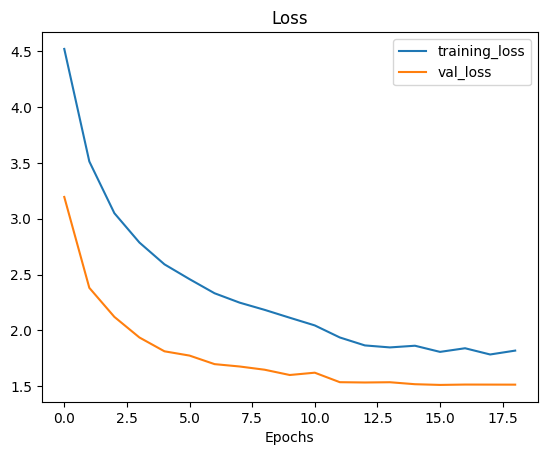

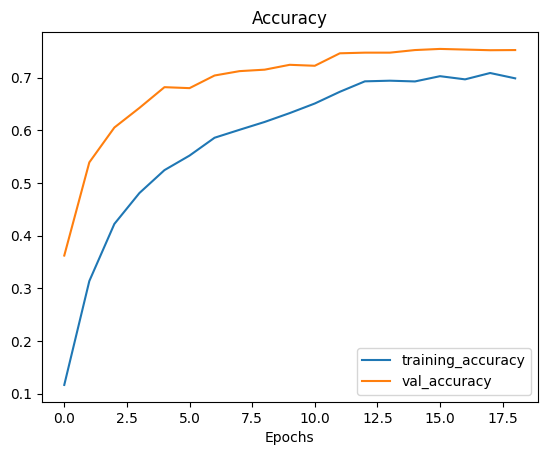

In [ ]:
save_model_and_history(model_7_EFFNet, history_7.history, model_7_EFFNet.name, mainDirectory + "/Model7/")
model_loaded, hystory_loaded = load_model_and_history(model_7_EFFNet.name, mainDirectory + "/Model7/")
plot_loss_curves(hystory_loaded)
predicted = test_model(model_loaded, test_data, test_dataset)

# Model 8 efficient net + Gru

In [ ]:
input=Input(shape=(320000))

x = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                    n_fft=CFG.nfft,
                                    hop_length=CFG.hop_length,
                                    sr=CFG.sample_rate,
                                    ref=1.0,
                                    out_channels=CFG.out_channels)(input)

base = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(input_shape=(128, 384, 3),

                                                              include_top=False,
                                                              weights ='imagenet',
                                                              include_preprocessing = True)

base.trainable = True
make_trainable(base, True)

x = tfe.layers.ZScoreMinMax()(x) * 255
x = base(x)

print(x.shape)
x = tf.transpose(x, perm=[0, 2, 1, 3])
print(x.shape)
x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
print(x.shape)

x = Bidirectional(GRU(128,return_sequences=True))(x)
x = Bidirectional(GRU(128,return_sequences=True))(x)
x = Dropout(0.5)(x)
x = LayerNormalization()(x)
x = Bidirectional(GRU(128,return_sequences=False))(x)
output = Dense(264)(x)

model_8_EFFNet2GRU = tf.keras.Model(input, output, name="EFF_NET_2_GRU")
model_8_EFFNet2GRU.summary()

28456008/28456008 [==============================] - 3s 0us/step
(None, 4, 12, 1280)
(None, 12, 4, 1280)
(None, 12, 5120)
Model: "EFF_NET_2_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320000)]          0         
                                                                 
 mel_spectrogram (MelSpectro  (None, 128, 384, 3)      0         
 gram)                                                           
                                                                 
 z_score_min_max (ZScoreMinM  (None, 128, 384, 3)      0         
 ax)                                                             
                                                                 
 tf.math.multiply (TFOpLambd  (None, 128, 384, 3)      0         
 a)                                                              
                                                               

In [ ]:
for layer_number, layer in enumerate(base.layers[:-3]):
    print(layer_number, layer.name, layer.trainable)

0 input_2 True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn False
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn False
8 block1a_project_activation True
9 block1b_project_conv True
10 block1b_project_bn False
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn False
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn False
19 block2b_expand_conv True
20 block2b_expand_bn False
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn False
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn False
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn False
31 block2c_drop True
32 block2c_add True
33 block3a_expand_conv True
34 block3a_expand_bn False
35 block3a_expand_activation True
36 block3a_project_conv True
37 block3a_project_bn False
38 b

In [ ]:
model_8_EFFNet2GRU.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
history_8 = model_8_EFFNet2GRU.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=60,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "model_8_EFFNet2GRU"), # track the model training logs
                                create_model_checkpoint(model_8_EFFNet2GRU.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
                                create_ReduceLROnPlateau(factor=0.2)])

Saving TensorBoard log files to: training_logs/model_8_EFFNet2GRU/20230616-195036
Epoch 1/60
1105/1105 [==============================] - ETA: 0s - loss: 4.1089 - accuracy: 0.2109

1105/1105 [==============================] - 1542s 1s/step - loss: 4.1089 - accuracy: 0.2109 - val_loss: 2.6238 - val_accuracy: 0.4903 - lr: 1.0000e-04
Epoch 2/60
1105/1105 [==============================] - ETA: 0s - loss: 3.0620 - accuracy: 0.4252

1105/1105 [==============================] - 558s 505ms/step - loss: 3.0620 - accuracy: 0.4252 - val_loss: 2.1022 - val_accuracy: 0.6131 - lr: 1.0000e-04
Epoch 3/60
1105/1105 [==============================] - ETA: 0s - loss: 2.6331 - accuracy: 0.5251

1105/1105 [==============================] - 593s 536ms/step - loss: 2.6331 - accuracy: 0.5251 - val_loss: 1.9206 - val_accuracy: 0.6519 - lr: 1.0000e-04
Epoch 4/60
1105/1105 [==============================] - ETA: 0s - loss: 2.3627 - accuracy: 0.5850

1105/1105 [==============================] - 570s 516ms/step - loss: 2.3627 - accuracy: 0.5850 - val_loss: 1.7707 - val_accuracy: 0.6891 - lr: 1.0000e-04
Epoch 5/60
1105/1105 [==============================] - ETA: 0s - loss: 2.1542 - accuracy: 0.6342

1105/1105 [==============================] - 571s 517ms/step - loss: 2.1542 - accuracy: 0.6342 - val_loss: 1.7307 - val_accuracy: 0.7085 - lr: 1.0000e-04
Epoch 6/60
1105/1105 [==============================] - ETA: 0s - loss: 2.0211 - accuracy: 0.6615

1105/1105 [==============================] - 585s 529ms/step - loss: 2.0211 - accuracy: 0.6615 - val_loss: 1.7041 - val_accuracy: 0.7070 - lr: 1.0000e-04
Epoch 7/60
1105/1105 [==============================] - ETA: 0s - loss: 1.9077 - accuracy: 0.6889

1105/1105 [==============================] - 561s 507ms/step - loss: 1.9077 - accuracy: 0.6889 - val_loss: 1.6763 - val_accuracy: 0.7135 - lr: 1.0000e-04
Epoch 8/60
1105/1105 [==============================] - ETA: 0s - loss: 1.8242 - accuracy: 0.7037
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1105/1105 [==============================] - 457s 413ms/step - loss: 1.8242 - accuracy: 0.7037 - val_loss: 1.7067 - val_accuracy: 0.7211 - lr: 1.0000e-04
Epoch 9/60
1105/1105 [==============================] - ETA: 0s - loss: 1.7089 - accuracy: 0.7328

1105/1105 [==============================] - 563s 510ms/step - loss: 1.7089 - accuracy: 0.7328 - val_loss: 1.6032 - val_accuracy: 0.7408 - lr: 2.0000e-05
Epoch 10/60
1105/1105 [==============================] - ETA: 0s - loss: 1.6535 - accuracy: 0.7443

1105/1105 [==============================] - 564s 511ms/step - loss: 1.6535 - accuracy: 0.7443 - val_loss: 1.5974 - val_accuracy: 0.7427 - lr: 2.0000e-05
Epoch 11/60
1105/1105 [==============================] - ETA: 0s - loss: 1.6312 - accuracy: 0.7513

1105/1105 [==============================] - 579s 524ms/step - loss: 1.6312 - accuracy: 0.7513 - val_loss: 1.5740 - val_accuracy: 0.7461 - lr: 2.0000e-05
Epoch 12/60
1105/1105 [==============================] - ETA: 0s - loss: 1.5934 - accuracy: 0.7571
Epoch 12: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
1105/1105 [==============================] - 454s 411ms/step - loss: 1.5934 - accuracy: 0.7571 - val_loss: 1.5844 - val_accuracy: 0.7479 - lr: 2.0000e-05
Epoch 13/60
1105/1105 [==============================] - ETA: 0s - loss: 1.5631 - accuracy: 0.7664

1105/1105 [==============================] - 563s 510ms/step - loss: 1.5631 - accuracy: 0.7664 - val_loss: 1.5630 - val_accuracy: 0.7544 - lr: 4.0000e-06
Epoch 14/60
1105/1105 [==============================] - ETA: 0s - loss: 1.5599 - accuracy: 0.7681
Epoch 14: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
1105/1105 [==============================] - 452s 409ms/step - loss: 1.5599 - accuracy: 0.7681 - val_loss: 1.5658 - val_accuracy: 0.7522 - lr: 4.0000e-06
Epoch 15/60
1105/1105 [==============================] - ETA: 0s - loss: 1.5761 - accuracy: 0.7664
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
1105/1105 [==============================] - 457s 414ms/step - loss: 1.5761 - accuracy: 0.7664 - val_loss: 1.5650 - val_accuracy: 0.7510 - lr: 8.0000e-07


Index 0
Index 1000
Index 2000
Index 3000
Using average probability
    accuracy  precision    recall        f1
0  80.272324    0.80385  0.802723  0.797883
Top 5 accuracy is:  0.9164027865737808
Classes with most mistakes
                      Name  Mistaken  All  Percent mistaken
111            Great Egret        18   53          0.339623
62            Cattle Egret        16   35          0.457143
71           Common Bulbul        15   62          0.241935
29   Black-backed Puffback        15   35          0.428571
21            Barn Swallow        14  105          0.133333
95                Garganey        14   29          0.482759
73     Common House-Martin        13   90          0.144444
93      Fork-tailed Drongo        12   29          0.413793
223       Variable Sunbird        12   22          0.545455
220   Tawny-flanked Prinia        12   34          0.352941
Using max logits
    accuracy  precision    recall        f1
0  79.955668   0.803366  0.799557  0.795892
Top 5 accuracy

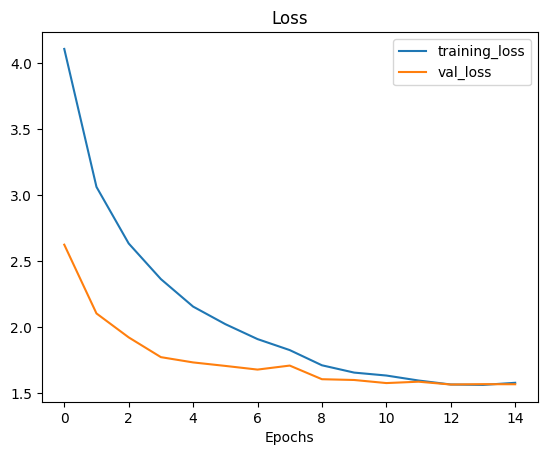

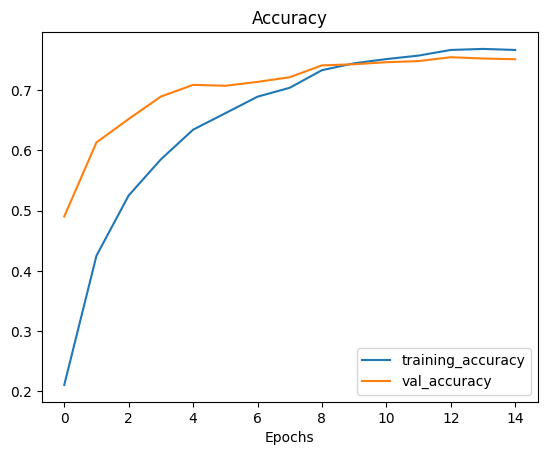

In [ ]:
save_model_and_history(model_8_EFFNet2GRU, history_8.history, model_8_EFFNet2GRU.name, mainDirectory + "/Model8/")
model_loaded, hystory_loaded = load_model_and_history(model_8_EFFNet2GRU.name, mainDirectory + "/Model8/")
plot_loss_curves(hystory_loaded)
predicted = test_model(model_loaded, test_data, test_dataset)

# Model 9 efficient net + CNN 2 GRU

In [ ]:

base_eff_net, _ = load_model_and_history("EFF_NET_1", mainDirectory + "/Model6/")

input_eff = base_eff_net.layers[0].output

y = base_eff_net.layers[1].output
z = base_eff_net.layers[-2].output

y = Normalization()(y)
y = Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(y)
y = LayerNormalization()(y)
y = Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(y)
y = LayerNormalization()(y)

print(y.shape)
y = tf.transpose(y, perm=[0, 2, 1, 3])
print(y.shape)
y = Reshape((-1, y.shape[-1] * y.shape[-2]))(y)
print(y.shape)

y = Bidirectional(GRU(128,return_sequences=True))(y)
y = Bidirectional(GRU(128,return_sequences=True))(y)
y = Dropout(0.5)(y)
y = LayerNormalization()(y)
y = Bidirectional(GRU(128,return_sequences=False))(y)


x = tf.keras.layers.Concatenate()([y, z])
output = Dense(264)(x)

model_9__EFF_2_CNN2GRU = tf.keras.Model(inputs = input_eff, outputs = output, name = "model_9__EFF_2_CNN2GRU")
model_9__EFF_2_CNN2GRU.summary()

(None, 64, 96, 64)
(None, 96, 64, 64)
(None, 96, 4096)
Model: "model_9__EFF_2_CNN2GRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320000)]     0           []                               
                                                                                                  
 mel_spectrogram (MelSpectrogra  (None, 128, 384, 3)  0          ['input_1[0][0]']                
 m)                                                                                               
                                                                                                  
 normalization_1 (Normalization  (None, 128, 384, 3)  7          ['mel_spectrogram[0][0]']        
 )                                                                                                
                      

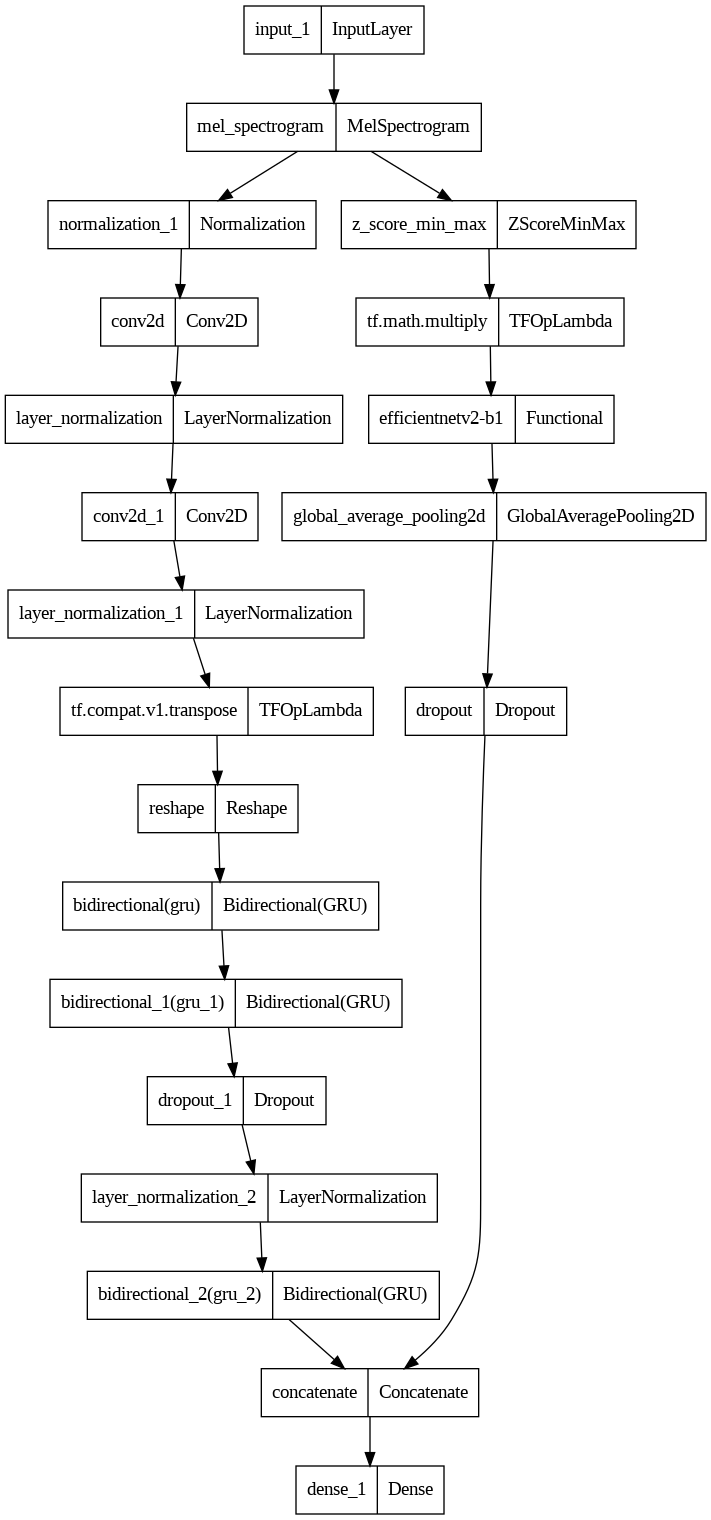

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_9__EFF_2_CNN2GRU)

In [ ]:
model_9__EFF_2_CNN2GRU.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
history_9 = model_9__EFF_2_CNN2GRU.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=40,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "model_9__EFF_2_CNN2GRU"), # track the model training logs
                                create_model_checkpoint(model_9__EFF_2_CNN2GRU.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
                                create_ReduceLROnPlateau(factor=0.2)])

Saving TensorBoard log files to: training_logs/model_9__EFF_2_CNN2GRU/20230617-111659
Epoch 1/40
1105/1105 [==============================] - ETA: 0s - loss: 2.8588 - accuracy: 0.5024

1105/1105 [==============================] - 718s 597ms/step - loss: 2.8588 - accuracy: 0.5024 - val_loss: 1.7083 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 2/40
1105/1105 [==============================] - ETA: 0s - loss: 2.1449 - accuracy: 0.6436

1105/1105 [==============================] - 653s 591ms/step - loss: 2.1449 - accuracy: 0.6436 - val_loss: 1.6403 - val_accuracy: 0.7261 - lr: 1.0000e-04
Epoch 3/40
1105/1105 [==============================] - ETA: 0s - loss: 2.0107 - accuracy: 0.6707
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1105/1105 [==============================] - 546s 494ms/step - loss: 2.0107 - accuracy: 0.6707 - val_loss: 1.6695 - val_accuracy: 0.7221 - lr: 1.0000e-04
Epoch 4/40
1105/1105 [==============================] - ETA: 0s - loss: 1.8497 - accuracy: 0.7032

1105/1105 [==============================] - 658s 596ms/step - loss: 1.8497 - accuracy: 0.7032 - val_loss: 1.5482 - val_accuracy: 0.7507 - lr: 2.0000e-05
Epoch 5/40
1105/1105 [==============================] - ETA: 0s - loss: 1.7783 - accuracy: 0.7234

1105/1105 [==============================] - 661s 598ms/step - loss: 1.7783 - accuracy: 0.7234 - val_loss: 1.5335 - val_accuracy: 0.7528 - lr: 2.0000e-05
Epoch 6/40
1105/1105 [==============================] - ETA: 0s - loss: 1.7551 - accuracy: 0.7226
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
1105/1105 [==============================] - 545s 493ms/step - loss: 1.7551 - accuracy: 0.7226 - val_loss: 1.5496 - val_accuracy: 0.7495 - lr: 2.0000e-05
Epoch 7/40
1105/1105 [==============================] - ETA: 0s - loss: 1.7057 - accuracy: 0.7383

1105/1105 [==============================] - 661s 599ms/step - loss: 1.7057 - accuracy: 0.7383 - val_loss: 1.5223 - val_accuracy: 0.7593 - lr: 4.0000e-06
Epoch 8/40
1105/1105 [==============================] - ETA: 0s - loss: 1.6970 - accuracy: 0.7386
Epoch 8: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
1105/1105 [==============================] - 547s 495ms/step - loss: 1.6970 - accuracy: 0.7386 - val_loss: 1.5259 - val_accuracy: 0.7553 - lr: 4.0000e-06
Epoch 9/40
1105/1105 [==============================] - ETA: 0s - loss: 1.6974 - accuracy: 0.7382
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
1105/1105 [==============================] - 544s 492ms/step - loss: 1.6974 - accuracy: 0.7382 - val_loss: 1.5224 - val_accuracy: 0.7572 - lr: 8.0000e-07


Index 0
Index 1000
Index 2000
Index 3000
Using average probability
    accuracy  precision   recall        f1
0  80.968968   0.813213  0.80969  0.806006
Top 5 accuracy is:  0.928435718809373
Classes with most mistakes
                      Name  Mistaken  All  Percent mistaken
111            Great Egret        20   53          0.377358
21            Barn Swallow        15  105          0.142857
223       Variable Sunbird        14   22          0.636364
88         Eurasian Hoopoe        14   92          0.152174
29   Black-backed Puffback        13   35          0.371429
62            Cattle Egret        13   35          0.371429
133           Little Egret        12   79          0.151899
220   Tawny-flanked Prinia        12   34          0.352941
95                Garganey        11   29          0.379310
93      Fork-tailed Drongo        11   29          0.379310
Using max logits
    accuracy  precision   recall        f1
0  80.113996   0.807888  0.80114  0.797558
Top 5 accuracy is: 

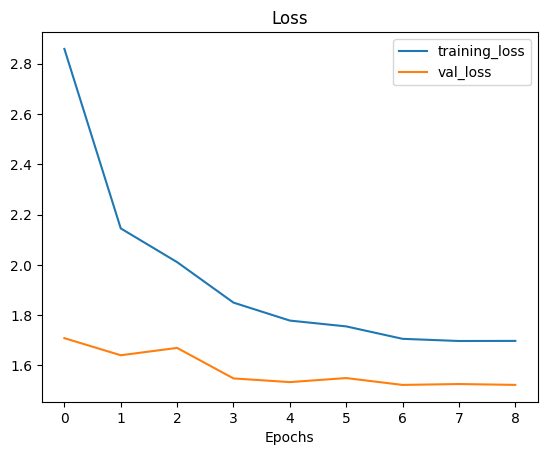

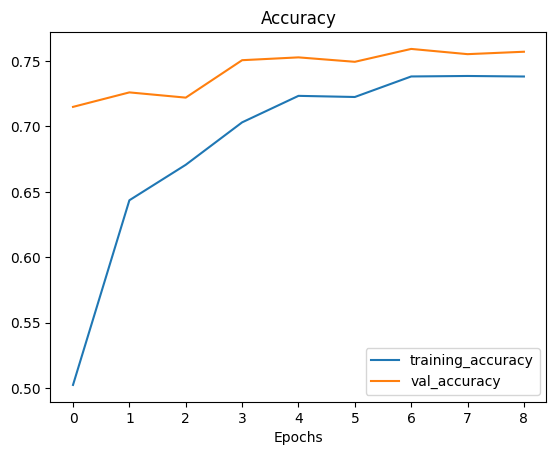

In [ ]:
save_model_and_history(model_9__EFF_2_CNN2GRU, history_9.history, model_9__EFF_2_CNN2GRU.name, mainDirectory + "/Model9/")
model_loaded, hystory_loaded = load_model_and_history(model_9__EFF_2_CNN2GRU.name, mainDirectory + "/Model9/")
plot_loss_curves(hystory_loaded)
predicted = test_model(model_loaded, test_data, test_dataset)

# Model 10 (Efficient Net + Time Freq Mask + GRU) + (CNN + GRU)

In [ ]:
base_cnn, _ = load_model_and_history("CONV_2_GRU", mainDirectory + "/Model2/")
base_eff_net, _ = load_model_and_history("EFF_NET_2", mainDirectory + "/Model7/")
for layer in base_cnn.layers:
    layer._name = layer.name + str("_cnnmodel")
for layer in base_eff_net.layers:
    layer._name = layer.name + str("_effnetmodel")

input_eff = base_eff_net.layers[0].output

y = base_eff_net.layers[3].output
for layer in base_cnn.layers[3:10]:
     y = layer(y)

y = tf.transpose(y, perm=[0, 2, 1, 3])
y = Reshape((-1, y.shape[-1] * y.shape[-2]))(y)

for layer in base_cnn.layers[12:-1]:
     y = layer(y)

z = base_eff_net.layers[-3].input

z = tf.transpose(z, perm=[0, 2, 1, 3])
z = Reshape((-1, z.shape[-1] * z.shape[-2]))(z)

z = Bidirectional(GRU(128,return_sequences=True))(z)
z = Bidirectional(GRU(128,return_sequences=True))(z)
z = Dropout(0.4)(z)
z = LayerNormalization()(z)
z = Bidirectional(GRU(128,return_sequences=False))(z)

x = tf.keras.layers.Concatenate()([y, z])
x = Dropout(0.25)(x)
x = Dense(1024, activation = 'relu')(x)
output = Dense(264)(x)

model_10__EFF2GRU_CNNGRU = tf.keras.Model(inputs = input_eff, outputs = output, name = "model_10__EFF2GRU_CNNGRU")
model_10__EFF2GRU_CNNGRU.summary()

Model: "model_10__EFF2GRU_CNNGRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_effnetmodel (InputLaye  [(None, 320000)]    0           []                               
 r)                                                                                               
                                                                                                  
 mel_spectrogram_effnetmodel (M  (None, 128, 384, 3)  0          ['input_1_effnetmodel[0][0]']    
 elSpectrogram)                                                                                   
                                                                                                  
 z_score_min_max_effnetmodel (Z  (None, 128, 384, 3)  0          ['mel_spectrogram_effnetmodel[0][
 ScoreMinMax)                                                    0]']      

In [ ]:
model_10__EFF2GRU_CNNGRU.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing, from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

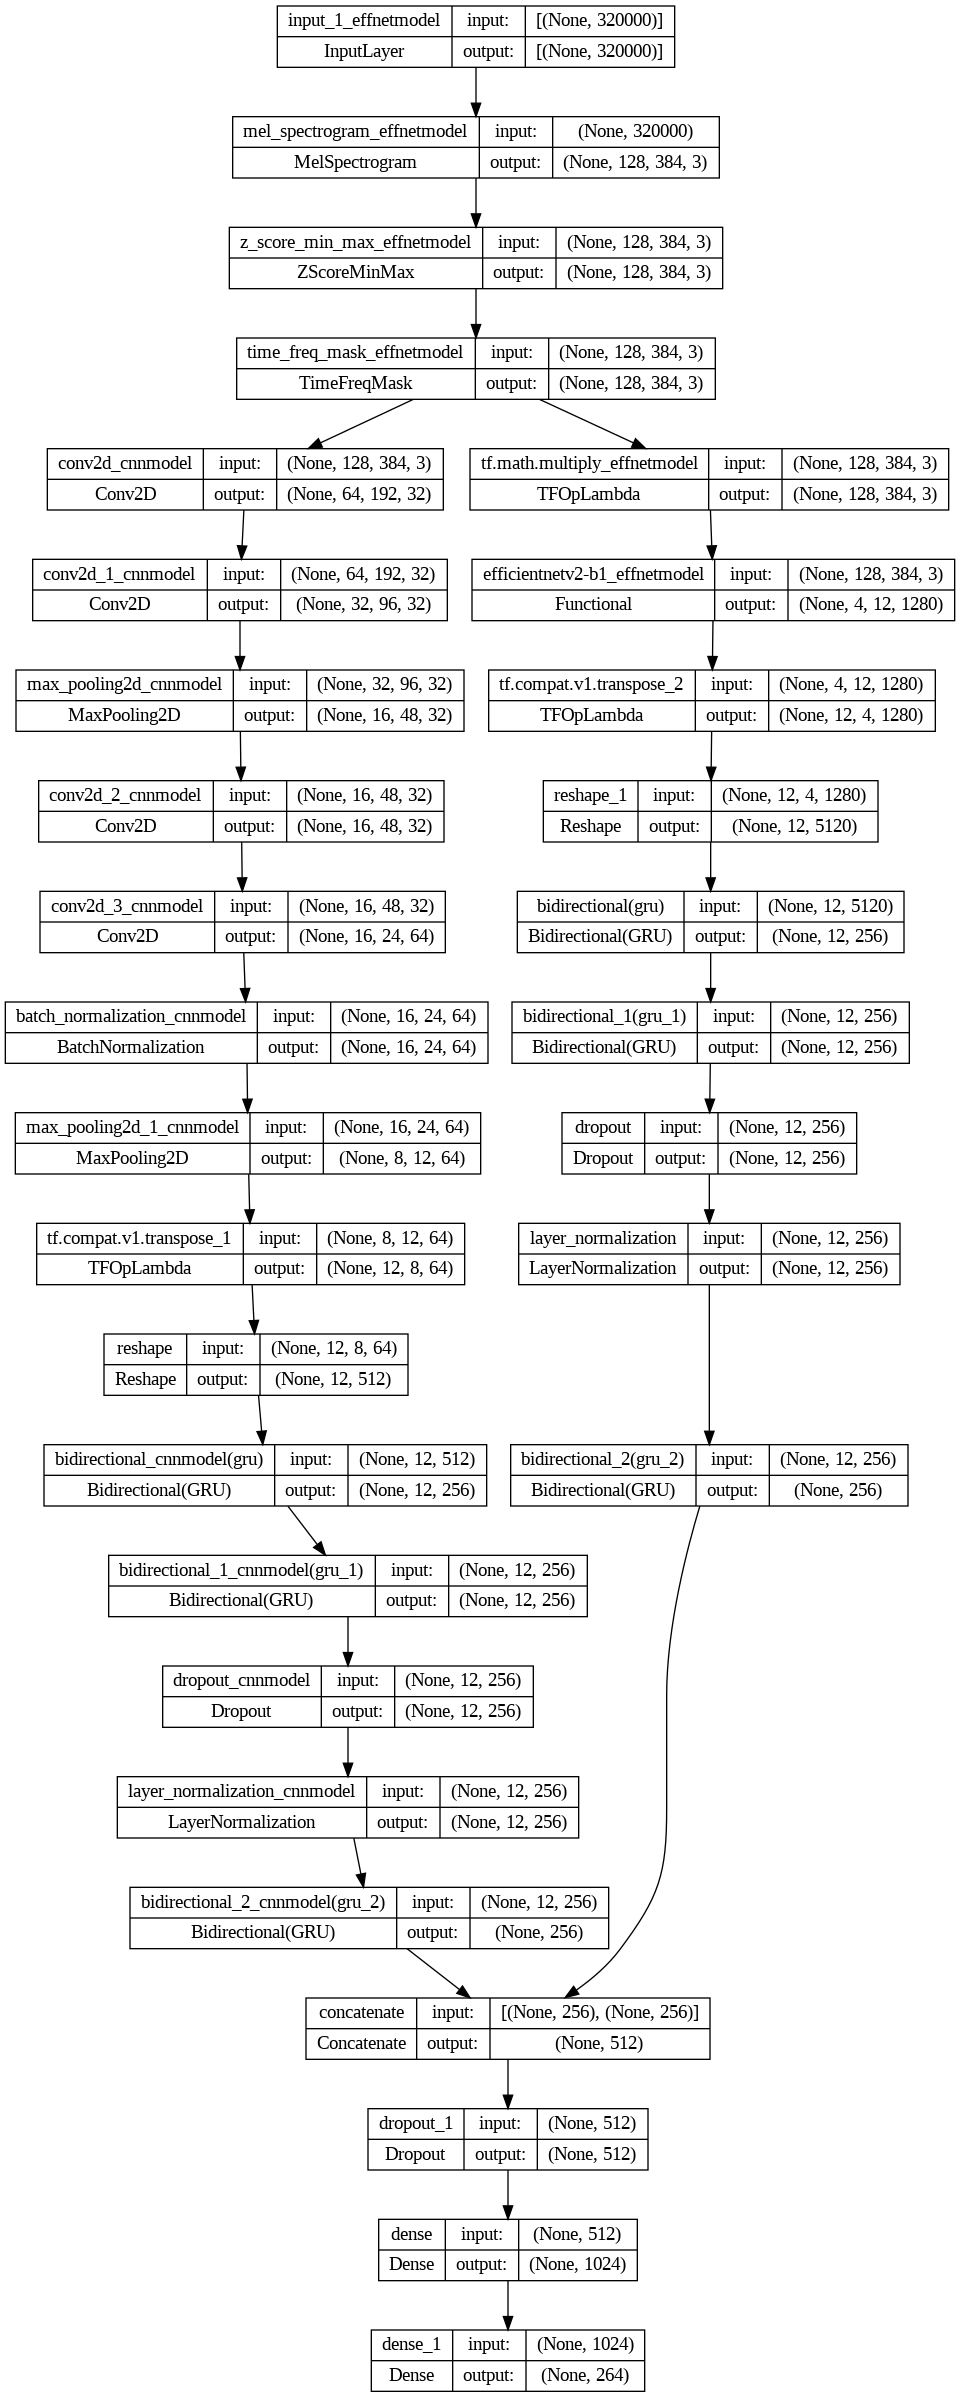

In [ ]:
from keras.utils import plot_model
plot_model(model_10__EFF2GRU_CNNGRU, show_shapes=True, show_layer_names=True)

In [ ]:
history_10 = model_10__EFF2GRU_CNNGRU.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=20,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "model_10__EFF2GRU_CNNGRU"), # track the model training logs
                                create_model_checkpoint(model_10__EFF2GRU_CNNGRU.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
                                create_ReduceLROnPlateau(factor=0.2)])

Saving TensorBoard log files to: training_logs/model_10__EFF2GRU_CNNGRU/20230618-151304
Epoch 1/20
1105/1105 [==============================] - ETA: 0s - loss: 3.0380 - accuracy: 0.4730

1105/1105 [==============================] - 1650s 1s/step - loss: 3.0380 - accuracy: 0.4730 - val_loss: 1.7899 - val_accuracy: 0.7011 - lr: 1.0000e-04
Epoch 2/20
1105/1105 [==============================] - ETA: 0s - loss: 2.2249 - accuracy: 0.6287

1105/1105 [==============================] - 666s 603ms/step - loss: 2.2249 - accuracy: 0.6287 - val_loss: 1.6959 - val_accuracy: 0.7313 - lr: 1.0000e-04
Epoch 3/20
1105/1105 [==============================] - ETA: 0s - loss: 2.0728 - accuracy: 0.6600
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1105/1105 [==============================] - 530s 480ms/step - loss: 2.0728 - accuracy: 0.6600 - val_loss: 1.7025 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 4/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8909 - accuracy: 0.6964

1105/1105 [==============================] - 669s 606ms/step - loss: 1.8909 - accuracy: 0.6964 - val_loss: 1.5796 - val_accuracy: 0.7581 - lr: 2.0000e-05
Epoch 5/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8081 - accuracy: 0.7154

1105/1105 [==============================] - 668s 604ms/step - loss: 1.8081 - accuracy: 0.7154 - val_loss: 1.5633 - val_accuracy: 0.7605 - lr: 2.0000e-05
Epoch 6/20
1105/1105 [==============================] - ETA: 0s - loss: 1.7915 - accuracy: 0.7158

1105/1105 [==============================] - 671s 607ms/step - loss: 1.7915 - accuracy: 0.7158 - val_loss: 1.5547 - val_accuracy: 0.7645 - lr: 2.0000e-05
Epoch 7/20
1105/1105 [==============================] - ETA: 0s - loss: 1.7500 - accuracy: 0.7274
Epoch 7: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
1105/1105 [==============================] - 531s 480ms/step - loss: 1.7500 - accuracy: 0.7274 - val_loss: 1.5595 - val_accuracy: 0.7562 - lr: 2.0000e-05
Epoch 8/20
1105/1105 [==============================] - ETA: 0s - loss: 1.7259 - accuracy: 0.7299

1105/1105 [==============================] - 672s 608ms/step - loss: 1.7259 - accuracy: 0.7299 - val_loss: 1.5529 - val_accuracy: 0.7596 - lr: 4.0000e-06
Epoch 9/20
1105/1105 [==============================] - ETA: 0s - loss: 1.7222 - accuracy: 0.7328
Epoch 9: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
1105/1105 [==============================] - 530s 479ms/step - loss: 1.7222 - accuracy: 0.7328 - val_loss: 1.5575 - val_accuracy: 0.7602 - lr: 4.0000e-06
Epoch 10/20
1105/1105 [==============================] - ETA: 0s - loss: 1.7047 - accuracy: 0.7360
Epoch 10: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
1105/1105 [==============================] - 528s 478ms/step - loss: 1.7047 - accuracy: 0.7360 - val_loss: 1.5541 - val_accuracy: 0.7612 - lr: 8.0000e-07


In [ ]:
history_10 = model_10__EFF2GRU_CNNGRU.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs=20,
                    batch_size=CFG.batch_size,
                    steps_per_epoch=((CFG.preferred_chunks * len(train_data)) // CFG.batch_size),
                    callbacks=[create_tensorboard_callback("training_logs", "model_10__EFF2GRU_CNNGRU"), # track the model training logs
                                create_model_checkpoint(model_10__EFF2GRU_CNNGRU.name), # save only the best model during training
                                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
                                create_ReduceLROnPlateau(factor=0.2)])

Saving TensorBoard log files to: training_logs/model_10__EFF2GRU_CNNGRU/20230618-182833
Epoch 1/20
1105/1105 [==============================] - ETA: 0s - loss: 3.0329 - accuracy: 0.4714

1105/1105 [==============================] - 1634s 1s/step - loss: 3.0329 - accuracy: 0.4714 - val_loss: 1.7858 - val_accuracy: 0.7042 - lr: 1.0000e-04
Epoch 2/20
1105/1105 [==============================] - ETA: 0s - loss: 2.2231 - accuracy: 0.6293

1105/1105 [==============================] - 668s 605ms/step - loss: 2.2231 - accuracy: 0.6293 - val_loss: 1.7225 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 3/20
1105/1105 [==============================] - ETA: 0s - loss: 2.0721 - accuracy: 0.6606

1105/1105 [==============================] - 677s 613ms/step - loss: 2.0721 - accuracy: 0.6606 - val_loss: 1.7215 - val_accuracy: 0.7208 - lr: 1.0000e-04
Epoch 4/20
1105/1105 [==============================] - ETA: 0s - loss: 1.9771 - accuracy: 0.6748

1105/1105 [==============================] - 674s 610ms/step - loss: 1.9771 - accuracy: 0.6748 - val_loss: 1.6557 - val_accuracy: 0.7387 - lr: 1.0000e-04
Epoch 5/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8960 - accuracy: 0.6930

1105/1105 [==============================] - 680s 615ms/step - loss: 1.8960 - accuracy: 0.6930 - val_loss: 1.6415 - val_accuracy: 0.7387 - lr: 1.0000e-04
Epoch 6/20
1105/1105 [==============================] - ETA: 0s - loss: 1.8502 - accuracy: 0.6988
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1105/1105 [==============================] - 534s 483ms/step - loss: 1.8502 - accuracy: 0.6988 - val_loss: 1.6448 - val_accuracy: 0.7405 - lr: 1.0000e-04
Epoch 7/20
1105/1105 [==============================] - ETA: 0s - loss: 1.7159 - accuracy: 0.7315

1105/1105 [==============================] - 673s 610ms/step - loss: 1.7159 - accuracy: 0.7315 - val_loss: 1.5606 - val_accuracy: 0.7584 - lr: 2.0000e-05
Epoch 8/20
1105/1105 [==============================] - ETA: 0s - loss: 1.6712 - accuracy: 0.7394
Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
1105/1105 [==============================] - 530s 479ms/step - loss: 1.6712 - accuracy: 0.7394 - val_loss: 1.5660 - val_accuracy: 0.7645 - lr: 2.0000e-05
Epoch 9/20
1105/1105 [==============================] - ETA: 0s - loss: 1.6542 - accuracy: 0.7427

1105/1105 [==============================] - 683s 618ms/step - loss: 1.6542 - accuracy: 0.7427 - val_loss: 1.5572 - val_accuracy: 0.7673 - lr: 4.0000e-06
Epoch 10/20
1105/1105 [==============================] - ETA: 0s - loss: 1.6380 - accuracy: 0.7447

1105/1105 [==============================] - 679s 614ms/step - loss: 1.6380 - accuracy: 0.7447 - val_loss: 1.5496 - val_accuracy: 0.7685 - lr: 4.0000e-06
Epoch 11/20
1105/1105 [==============================] - ETA: 0s - loss: 1.6270 - accuracy: 0.7534

1105/1105 [==============================] - 681s 617ms/step - loss: 1.6270 - accuracy: 0.7534 - val_loss: 1.5455 - val_accuracy: 0.7695 - lr: 4.0000e-06
Epoch 12/20
1105/1105 [==============================] - ETA: 0s - loss: 1.6451 - accuracy: 0.7430

1105/1105 [==============================] - 680s 615ms/step - loss: 1.6451 - accuracy: 0.7430 - val_loss: 1.5432 - val_accuracy: 0.7685 - lr: 4.0000e-06
Epoch 13/20
1105/1105 [==============================] - ETA: 0s - loss: 1.6166 - accuracy: 0.7507
Epoch 13: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
1105/1105 [==============================] - 537s 485ms/step - loss: 1.6166 - accuracy: 0.7507 - val_loss: 1.5435 - val_accuracy: 0.7695 - lr: 4.0000e-06
Epoch 14/20
1105/1105 [==============================] - ETA: 0s - loss: 1.6161 - accuracy: 0.7499

1105/1105 [==============================] - 668s 605ms/step - loss: 1.6161 - accuracy: 0.7499 - val_loss: 1.5421 - val_accuracy: 0.7710 - lr: 8.0000e-07
Epoch 15/20
1105/1105 [==============================] - ETA: 0s - loss: 1.6486 - accuracy: 0.7464

1105/1105 [==============================] - 673s 609ms/step - loss: 1.6486 - accuracy: 0.7464 - val_loss: 1.5411 - val_accuracy: 0.7704 - lr: 8.0000e-07
Epoch 16/20
1105/1105 [==============================] - ETA: 0s - loss: 1.6037 - accuracy: 0.7524

1105/1105 [==============================] - 676s 611ms/step - loss: 1.6037 - accuracy: 0.7524 - val_loss: 1.5399 - val_accuracy: 0.7735 - lr: 8.0000e-07
Epoch 17/20
   9/1105 [..............................] - ETA: 8:48 - loss: 1.6448 - accuracy: 0.7639

KeyboardInterrupt: ignored

In [ ]:
for i in range(len(model_10__EFF2GRU_CNNGRU.weights)):
    model_10__EFF2GRU_CNNGRU.weights[i]._handle_name = model_10__EFF2GRU_CNNGRU.weights[i].name.split(":")[0] + str(i) + ":0"

NameError: ignored

In [ ]:
model_10__EFF2GRU_CNNGRU.save(mainDirectory + "/Model10/Full")

In [ ]:
model_10__EFF2GRU_CNNGRU = tf.keras.models.load_model(mainDirectory + "/Model10/Full")

In [ ]:
# save_model_and_history(model_10__EFF2GRU_CNNGRU, history_10.history, model_10__EFF2GRU_CNNGRU.name, mainDirectory + "/Model10/")
# model_loaded, hystory_loaded = load_model_and_history(model_10__EFF2GRU_CNNGRU.name, mainDirectory + "/Model10/")
# plot_loss_curves(hystory_loaded)
# predicted = test_model(model_loaded, test_data, test_dataset)

In [ ]:
predicted = test_model(model_10__EFF2GRU_CNNGRU, test_data, test_dataset)

Index 0
Index 1000
Index 2000
Index 3000
Using average probability
    accuracy  precision    recall        f1
0  82.077264   0.826841  0.820773  0.818067
Top 5 accuracy is:  0.9274857504749842
Classes with most mistakes
                        Name  Mistaken  All  Percent mistaken
21              Barn Swallow        14  105          0.133333
29     Black-backed Puffback        14   35          0.400000
88           Eurasian Hoopoe        14   92          0.152174
111              Great Egret        14   53          0.264151
71             Common Bulbul        12   62          0.193548
133             Little Egret        12   79          0.151899
93        Fork-tailed Drongo        12   29          0.413793
103  Gray-backed Camaroptera        11   50          0.220000
73       Common House-Martin        10   90          0.111111
223         Variable Sunbird        10   22          0.454545
Using max logits
    accuracy  precision    recall        f1
0  82.077264   0.827411  0.820773  0

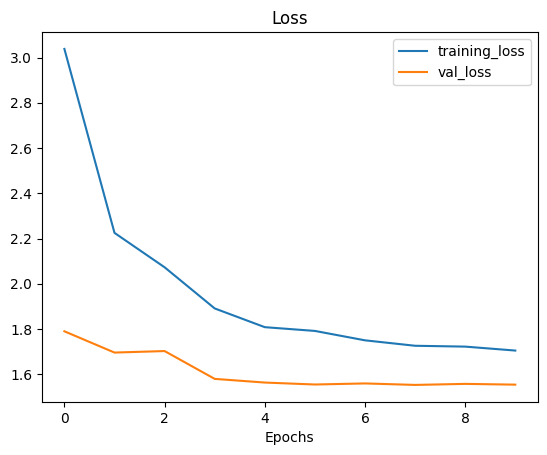

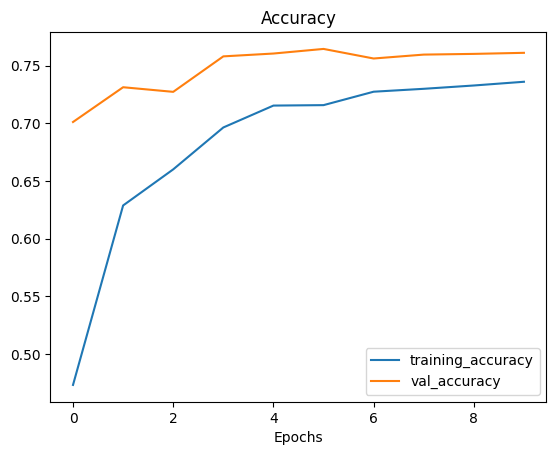

In [ ]:
plot_loss_curves(history_10.history)